### Требования к исходным данным
1. Данные для каждого региона должны быть расположены в отдельных файлах (пример: Moscow.csv, Lipetsk.csv)
2. Каждый файл должен содержать следующие столбцы: 
- time (Время в !!!UTC!!!. Пример: 2018-01-01 02:00:00+00:00) 
- temperature_2m (температура воздуха в °C. Пример: -0.25)
- relative_humidity_2m (относительная влажность воздуха в %. Пример: 97.85404)
- surface_pressure (давление над поверхностью земли в hPa. Пример: 986.15814)

In [1]:
import pandas as pd
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
from DataUtils import fit_scalers, MultiStationWindowDataset, make_loader, build_node_features_all, build_knn_edge_index, build_edge_weight, summarize_graph, solar_datetime_and_geometry, process_data
import lightning.pytorch as pl
from ModelModules import StationGNN, EncoderDecoderTCN, EncoderDecoderTCN_static, EMA, StudentModel, TeacherModel
import torch.nn as nn
from ModelUtils import HorizonLossConfig, HorizonWeightedLoss
from typing import Optional
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
from lightning.pytorch.loggers import CSVLogger 
from Callbacks import StaticDropoutAnnealCallback, FreezeGNNOnDeltaCallback, LossWarmupAnnealCallback
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
import umap
import copy
from TestUtils import *

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ===== ГЕОТОЧКИ ДЛЯ ОБУЧАЮЩЕГО И ТЕСТОВОГО НАБОРА =====
geo_points = [
    {'name': 'Moscow', 'lat': 55.7522, 'lng': 37.6156, 'alt': 143},
    {'name': 'SPB', 'lat': 59.9386, 'lng': 30.3141, 'alt': 12},
    {'name': 'Minsk', 'lat': 53.900, 'lng': 27.5667, 'alt': 220},
    {'name': 'Kiev', 'lat': 50.4547, 'lng': 30.5238, 'alt': 184},
    {'name': 'Krasnodar', 'lat': 45.0448, 'lng': 38.9760, 'alt': 29},
    {'name': 'Tbilisi', 'lat': 41.717085, 'lng': 44.757828, 'alt': 575},
    {'name': 'Siktivkar', 'lat': 61.6764, 'lng': 50.8099, 'alt': 129},
    {'name': 'EKB', 'lat': 56.8519, 'lng': 60.6122, 'alt': 255},
    {'name': 'Orenburg', 'lat': 51.7727, 'lng': 55.0988, 'alt': 107},
    {'name': 'Kazan', 'lat': 55.7887, 'lng': 49.1221, 'alt': 65},
    {'name': 'Vologda', 'lat': 59.2239, 'lng': 39.8840, 'alt': 125},
    {'name': 'Arhangelsk', 'lat': 64.551643, 'lng': 40.486791, 'alt': 6},
    {'name': 'Saratov', 'lat': 51.5406, 'lng': 46.0086, 'alt': 71},
    {'name': 'Volgograd', 'lat': 48.7194, 'lng': 44.5018, 'alt': 65},
    {'name': 'Lipetsk', 'lat': 52.6031, 'lng': 39.5708, 'alt': 143},
    {'name': 'Kirov', 'lat': 58.5966, 'lng': 49.6601, 'alt': 156}
]

## Создание признаков

In [3]:
# ===== ОБРАБОТКА И ОБЪЕДИНЕНИЕ ДАННЫХ =====
# ВНИМАНИЕ: ОБРАТИТЕ ВНИМАНИЕ НА ПУТЬ К ДАННЫМ И НА ИХ СОДЕРЖИМОЕ. ТРЕБОВАНИЯ К ДАННЫМ УКАЗАНЫ В НАЧАЛЕ ФАЙЛА
dataframes = []
for i, reg in enumerate(geo_points):
    data = pd.read_csv(f'data/{reg["name"]}.csv')
    data['latitude'] = reg['lat']
    data['longitude'] = reg['lng']
    data['altitude'] = reg['alt']
    data['station_id'] = i
    dat = process_data(data)
    dataframes.append(dat)

ready_data = pd.concat(dataframes, ignore_index=True)

In [4]:
# Сохранение объединенного и обработанного DataFrame в новый CSV файл для удобства дальнейшей работы. Пропустить при необходимости.
# ready_data.to_csv('data/ready_data.csv', index=False)

In [5]:
# Загрузка обработанных данных для дальнейшего использования. Пропустить при необходимости, если уже работаете с ready_data.
# ready_data = pd.read_csv('data/ready_data.csv')
# ready_data['time'] = pd.to_datetime(ready_data['time'], utc=True)

In [6]:
# Проверка формы итогового DataFrame
ready_data.shape

(1121664, 27)

In [7]:
# Проверка информации о столбцах и типах данных
ready_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121664 entries, 0 to 1121663
Data columns (total 27 columns):
 #   Column                                Non-Null Count    Dtype              
---  ------                                --------------    -----              
 0   time                                  1121664 non-null  datetime64[ns, UTC]
 1   temperature_2m                        1121664 non-null  float64            
 2   relative_humidity_2m                  1121664 non-null  float64            
 3   surface_pressure                      1121664 non-null  float64            
 4   station_id                            1121664 non-null  int64              
 5   solar_cos_zenith                      1121664 non-null  float64            
 6   solar_doy_sin                         1121664 non-null  float64            
 7   solar_doy_cos                         1121664 non-null  float64            
 8   temperature_2m_diff_1                 1121664 non-null  float64         

In [8]:
train_geo_points = geo_points[:14]  # первые 14 точек для обучения

In [9]:
# ===== ПОСТРОЕНИЕ ГРАФА ДЛЯ ТРЕНИРОВКИ И ВЫВОД ИНФОРМАЦИИ О НЁМ =====
# ВНИМАНИЕ: Убедитесь, что используете train_geo_points для построения графа обучения, а не весь geo_points, если в дальнейшем планируете использовать только часть точек для обучения.
node_features_all_train = build_node_features_all(train_geo_points) # [14, 4] 
edge_index_train, dist_km_train = build_knn_edge_index(train_geo_points, k=4, undirected=True) # [2, num_edges]
edge_weight_train = build_edge_weight(edge_index_train, dist_km_train, tau_km=250.0) # [num_edges]

summarize_graph(train_geo_points, edge_index_train, dist_km_train)

Out-degrees (should be ~k or ~2k depending on undirected):
  00 Moscow: 10
  01 SPB: 8
  02 Minsk: 7
  03 Kiev: 6
  04 Krasnodar: 7
  05 Tbilisi: 6
  06 Siktivkar: 8
  07 EKB: 6
  08 Orenburg: 9
  09 Kazan: 9
  10 Vologda: 10
  11 Arhangelsk: 7
  12 Saratov: 10
  13 Volgograd: 9

Nearest neighbors by distance:
  00 Moscow: Vologda(409km), SPB(634km), Minsk(675km), Kazan(719km)
  01 SPB: Vologda(544km), Moscow(634km), Minsk(692km), Arhangelsk(734km)
  02 Minsk: Kiev(433km), Moscow(675km), SPB(692km), Vologda(957km)
  03 Kiev: Minsk(433km), Moscow(755km), Krasnodar(871km), Volgograd(1024km)
  04 Krasnodar: Volgograd(586km), Tbilisi(596km), Kiev(871km), Saratov(889km)
  05 Tbilisi: Krasnodar(596km), Volgograd(779km), Saratov(1096km), Orenburg(1365km)
  06 Siktivkar: Arhangelsk(609km), Vologda(657km), Kazan(662km), EKB(772km)
  07 EKB: Orenburg(668km), Kazan(717km), Siktivkar(772km), Saratov(1115km)
  08 Orenburg: Kazan(594km), Saratov(627km), EKB(668km), Volgograd(825km)
  09 Kazan: Sarat

In [10]:
# ===== ПОСТРОЕНИЕ ГРАФА ДЛЯ ТЕСТА И ВЫВОД ИНФОРМАЦИИ О НЁМ =====
node_features_all_test = build_node_features_all(geo_points)  # [16, 4]
edge_index_test, dist_km_test = build_knn_edge_index(geo_points, k=4, undirected=True) # [2, num_edges]
edge_weight_test = build_edge_weight(edge_index_test, dist_km_test, tau_km=250.0) # [num_edges]

summarize_graph(geo_points, edge_index_test, dist_km_test)

Out-degrees (should be ~k or ~2k depending on undirected):
  00 Moscow: 9
  01 SPB: 8
  02 Minsk: 7
  03 Kiev: 7
  04 Krasnodar: 7
  05 Tbilisi: 6
  06 Siktivkar: 8
  07 EKB: 6
  08 Orenburg: 7
  09 Kazan: 9
  10 Vologda: 9
  11 Arhangelsk: 7
  12 Saratov: 9
  13 Volgograd: 9
  14 Lipetsk: 11
  15 Kirov: 9

Nearest neighbors by distance:
  00 Moscow: Lipetsk(373km), Vologda(409km), SPB(634km), Minsk(675km)
  01 SPB: Vologda(544km), Moscow(634km), Minsk(692km), Arhangelsk(734km)
  02 Minsk: Kiev(433km), Moscow(675km), SPB(692km), Lipetsk(810km)
  03 Kiev: Minsk(433km), Lipetsk(669km), Moscow(755km), Krasnodar(871km)
  04 Krasnodar: Volgograd(586km), Tbilisi(596km), Lipetsk(842km), Kiev(871km)
  05 Tbilisi: Krasnodar(596km), Volgograd(779km), Saratov(1096km), Lipetsk(1272km)
  06 Siktivkar: Kirov(348km), Arhangelsk(609km), Vologda(657km), Kazan(662km)
  07 EKB: Orenburg(668km), Kirov(678km), Kazan(717km), Siktivkar(772km)
  08 Orenburg: Kazan(594km), Saratov(627km), EKB(668km), Volgograd

In [11]:
# ===== ФУНКЦИЯ ДЛЯ ВИЗУАЛИЗАЦИИ ГРАФА НА КАРТЕ =====
def plot_station_graph(
    geo_points,
    edge_index,
    edge_weight=None,
    title="Station graph (lat/lon)",
    min_lw=0.5,
    max_lw=4.0,
):
    '''Визуализация графа на карте с помощью matplotlib. Узлы отображаются в виде точек, рёбра - в виде линий. Если edge_weight задан, то толщина линий пропорциональна весу ребра'''
    lats = np.array([p["lat"] for p in geo_points], dtype=float)
    lons = np.array([p["lng"] for p in geo_points], dtype=float)
    names = [p["name"] for p in geo_points]

    src = edge_index[0].cpu().numpy()
    dst = edge_index[1].cpu().numpy()

    if edge_weight is not None:
        w = edge_weight.detach().cpu().numpy().astype(float)

        # нормализация весов в диапазон [min_lw, max_lw]
        if np.allclose(w.max(), w.min()):
            lw = np.full_like(w, (min_lw + max_lw) / 2)
        else:
            w_norm = (w - w.min()) / (w.max() - w.min())
            lw = min_lw + w_norm * (max_lw - min_lw)
    else:
        lw = np.ones(len(src))

    plt.figure(figsize=(10, 8))

    # рёбра
    for i, (s, d) in enumerate(zip(src, dst)):
        plt.plot(
            [lons[s], lons[d]],
            [lats[s], lats[d]],
            linewidth=lw[i],
            alpha=0.7,
            color="tab:blue",
        )

    # узлы
    plt.scatter(lons, lats, s=80, color="black", zorder=3)

    # подписи
    for i, (x, y) in enumerate(zip(lons, lats)):
        plt.text(
            x, y,
            f" {i}:{names[i]}",
            fontsize=9,
            ha="left",
            va="center",
            zorder=4,
        )

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.grid(True)
    plt.axis("equal")
    plt.show()

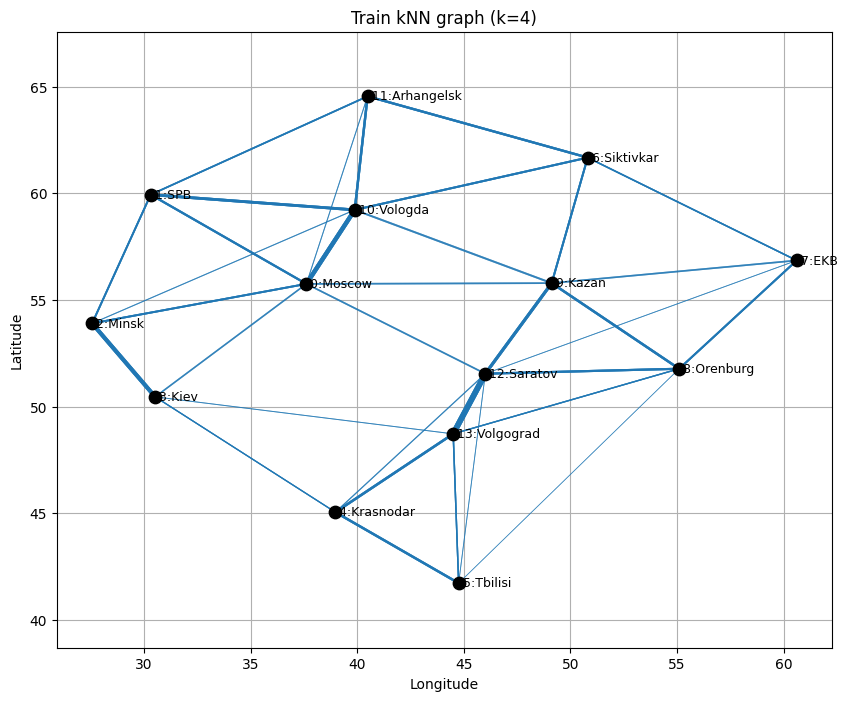

In [12]:
# Граф для обучения
plot_station_graph(train_geo_points, edge_index_train, edge_weight=edge_weight_train, title="Train kNN graph (k=4)")

In [13]:
# Смотрим детали узлов для обучения
static_stations_train = {}
for i, point in enumerate(train_geo_points):
    static_stations_train[i] = node_features_all_train[i].numpy()  # [4]
static_stations_train

{0: array([0.44578585, 0.3434947 , 0.8266114 , 0.143     ], dtype=float32),
 1: array([0.43243662, 0.25283837, 0.86548907, 0.012     ], dtype=float32),
 2: array([0.52230644, 0.2726688 , 0.8079899 , 0.22      ], dtype=float32),
 3: array([0.54845476, 0.3233715 , 0.77112144, 0.184     ], dtype=float32),
 4: array([0.5492815 , 0.44441858, 0.7076595 , 0.029     ], dtype=float32),
 5: array([0.53003883, 0.52557695, 0.665453  , 0.575     ], dtype=float32),
 6: array([0.29980338, 0.36772493, 0.880282  , 0.129     ], dtype=float32),
 7: array([0.2683272 , 0.4764412 , 0.83725995, 0.255     ], dtype=float32),
 8: array([0.35404462, 0.5074884 , 0.78556216, 0.107     ], dtype=float32),
 9: array([0.3679618 , 0.42511794, 0.8269697 , 0.065     ], dtype=float32),
 10: array([0.39263818, 0.3281102 , 0.8591734 , 0.125     ], dtype=float32),
 11: array([0.32680884, 0.2789908 , 0.90297294, 0.006     ], dtype=float32),
 12: array([0.43198252, 0.44746536, 0.7830491 , 0.071     ], dtype=float32),
 13: arra

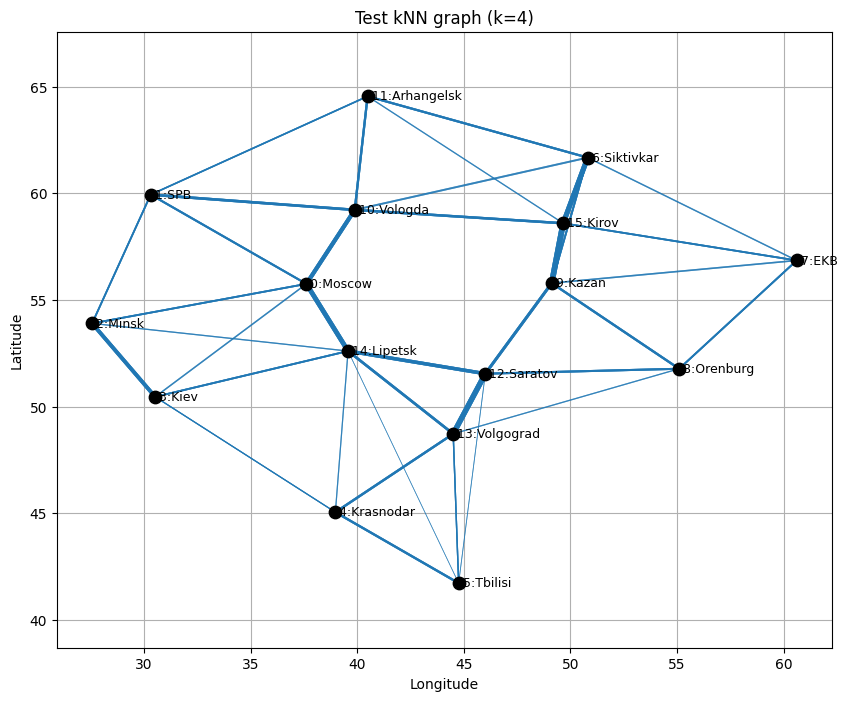

In [14]:
# Граф для теста
plot_station_graph(geo_points, edge_index_test, edge_weight=edge_weight_test, title="Test kNN graph (k=4)")

In [15]:
# Смотрим детали узлов для теста
static_stations_test = {}
for i, point in enumerate(geo_points):
    static_stations_test[i] = node_features_all_test[i].numpy()  # [4]
static_stations_test

{0: array([0.44578585, 0.3434947 , 0.8266114 , 0.143     ], dtype=float32),
 1: array([0.43243662, 0.25283837, 0.86548907, 0.012     ], dtype=float32),
 2: array([0.52230644, 0.2726688 , 0.8079899 , 0.22      ], dtype=float32),
 3: array([0.54845476, 0.3233715 , 0.77112144, 0.184     ], dtype=float32),
 4: array([0.5492815 , 0.44441858, 0.7076595 , 0.029     ], dtype=float32),
 5: array([0.53003883, 0.52557695, 0.665453  , 0.575     ], dtype=float32),
 6: array([0.29980338, 0.36772493, 0.880282  , 0.129     ], dtype=float32),
 7: array([0.2683272 , 0.4764412 , 0.83725995, 0.255     ], dtype=float32),
 8: array([0.35404462, 0.5074884 , 0.78556216, 0.107     ], dtype=float32),
 9: array([0.3679618 , 0.42511794, 0.8269697 , 0.065     ], dtype=float32),
 10: array([0.39263818, 0.3281102 , 0.8591734 , 0.125     ], dtype=float32),
 11: array([0.32680884, 0.2789908 , 0.90297294, 0.006     ], dtype=float32),
 12: array([0.43198252, 0.44746536, 0.7830491 , 0.071     ], dtype=float32),
 13: arra

# Подготовка данных

In [67]:
ready_data[ready_data['station_id'] == 14][['solar_cos_zenith', 'solar_doy_sin', 'solar_doy_cos', 'time']].iloc[-8760:]

solar_cos_zenith  solar_doy_sin  solar_doy_cos  \
1042800         -0.747166       0.017202       0.999852   
1042801         -0.641938       0.017202       0.999852   
1042802         -0.514127       0.017202       0.999852   
1042803         -0.372444       0.017202       0.999852   
1042804         -0.226544       0.017202       0.999852   
...                   ...            ...            ...   
1051555         -0.762108      -0.004167       0.999991   
1051556         -0.832245      -0.004167       0.999991   
1051557         -0.866894      -0.004167       0.999991   
1051558         -0.863696       0.017202       0.999852   
1051559         -0.822866       0.017202       0.999852   

                             time  
1042800 2025-01-01 00:00:00+00:00  
1042801 2025-01-01 01:00:00+00:00  
1042802 2025-01-01 02:00:00+00:00  
1042803 2025-01-01 03:00:00+00:00  
1042804 2025-01-01 04:00:00+00:00  
...                           ...  
1051555 2025-12-31 19:00:00+00:00  
1051556 2025-12-31 20:00:00+00:00  
1051557 2025-12-31 21:00:00+00:00  
1051558 2025-12-31 22:00:00+00:00  
1051559 2025-12-31 23:00:00+00:00  

[8760 rows x 4 columns]

In [ ]:
# ===== ПОДГОТОВКА ДАТАСЕТОВ И ЛОДЕРОВ ДЛЯ ОБУЧЕНИЯ И ТЕСТИРОВАНИЯ МОДЕЛИ =====
L = 672 # История 28 дней * 24 часа
H = 168 # Горизонт 7 дней * 24 часа

hist_num_cols = ['temperature_2m', 'relative_humidity_2m', 'surface_pressure', 'temperature_2m_diff_1', 'temperature_2m_diff_24', 
                 'relative_humidity_2m_diff_1', 'relative_humidity_2m_diff_24', 'surface_pressure_diff_1', 'surface_pressure_diff_24', 
                 'temperature_2m_rolling_std_6', 'temperature_2m_rolling_mean_6', 'temperature_2m_rolling_std_24', 'temperature_2m_rolling_mean_24', 
                 'relative_humidity_2m_rolling_std_6', 'relative_humidity_2m_rolling_mean_6', 'relative_humidity_2m_rolling_std_24', 'relative_humidity_2m_rolling_mean_24', 
                 'surface_pressure_rolling_std_6', 'surface_pressure_rolling_mean_6', 'surface_pressure_rolling_std_24', 'surface_pressure_rolling_mean_24', 'dewpoint']
hist_time_cols = ['solar_cos_zenith', 'solar_doy_sin', 'solar_doy_cos']
fut_cov_cols = ['solar_cos_zenith', 'solar_doy_sin', 'solar_doy_cos']
target_col = "temperature_2m"

batch_size = 56 # 56 = 14 станций * 4 (примерно по 4 примера на станцию в каждом батче)

# test_start = max_time - 365 days
test_start = ready_data["time"].max() - pd.Timedelta(days=365)

# Подгоняем скейлеры только на тренировочных данных (первые 14 станций)
hist_scaler = fit_scalers(
    ready_data[ready_data['station_id'] <= 13],
    test_start=test_start,
    val_days=90,
    hist_num_cols=hist_num_cols,
)

torch.save(hist_scaler.state_dict(), 'scaler.pt')

# Создание датасетов для обучения, валидации и тестирования
# ВНИМАНИЕ: Убедитесь, что используете static_stations_train для тренировочных датасетов и теста на видимых станциях, а static_stations_test для тестовых датасетов на невидимых станциях.
ds_train = MultiStationWindowDataset(
    ready_data, L=L, H=H,
    hist_num_cols=hist_num_cols,
    hist_time_cols=hist_time_cols,
    fut_cov_cols=fut_cov_cols,
    target_col=target_col,
    hist_num_scaler=hist_scaler,
    mode="train",
    test_start=test_start,
    val_days=365,
    static_by_station=static_stations_train,
    allowed_station_ids=list(range(14)),  # только первые 14 станций для обучения
)

ds_val = MultiStationWindowDataset(
    ready_data, L=L, H=H,
    hist_num_cols=hist_num_cols,
    hist_time_cols=hist_time_cols,
    fut_cov_cols=fut_cov_cols,
    target_col=target_col,
    hist_num_scaler=hist_scaler,
    mode="val",
    test_start=test_start,
    val_days=365,
    static_by_station=static_stations_train,
    allowed_station_ids=list(range(14)),  # только первые 14 станций для валидации
)

ds_test_seen = MultiStationWindowDataset(
    ready_data, L=L, H=H,
    hist_num_cols=hist_num_cols,
    hist_time_cols=hist_time_cols,
    fut_cov_cols=fut_cov_cols,
    target_col=target_col,
    hist_num_scaler=hist_scaler,
    mode="test",
    test_start=test_start,
    val_days=365,
    static_by_station=static_stations_train,
    allowed_station_ids=[10, 12], # только станции 10 и 12 для теста на видимых станциях
)

ds_test_unseen = MultiStationWindowDataset(
    ready_data, L=L, H=H,
    hist_num_cols=hist_num_cols,
    hist_time_cols=hist_time_cols,
    fut_cov_cols=fut_cov_cols,
    target_col=target_col,
    hist_num_scaler=hist_scaler,
    mode="test",
    test_start=test_start,
    val_days=365,
    static_by_station=static_stations_test,
    allowed_station_ids=[14, 15],
)

# Создание DataLoader-ов для каждого датасета
train_loader = make_loader(ds_train, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = make_loader(ds_val, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = make_loader(ds_test_seen, batch_size=batch_size, shuffle=False, num_workers=0)
test_unseen_loader = make_loader(ds_test_unseen, batch_size=batch_size, shuffle=False, num_workers=0)

In [17]:
# Проверяем количество батчей в каждом DataLoader-е
len(train_loader), len(val_loader), len(test_loader), len(test_unseen_loader)

(12978, 2190, 306, 306)

# Создание модели

In [18]:
# ===== ФУНКЦИЯ ДЛЯ ФИКСАЦИИ СЛУЧАЙНОСТИ =====
def seed_everything_strict(seed: int = 42):
    # numpy
    np.random.seed(seed)

    # torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # lightning helper
    pl.seed_everything(seed, workers=True)

seed_everything_strict(42)

Seed set to 42


# Обучение Teacher модели

In [19]:
# ===== ОПРЕДЕЛЕНИЕ МОДУЛЯ ОБУЧЕНИЯ =====
class TeacherLightning(pl.LightningModule):
    def __init__(
        self,
        model: TeacherModel,
        node_features_all: torch.Tensor,
        edge_index: torch.Tensor,
        edge_weight: Optional[torch.Tensor],
        loss_cfg: HorizonLossConfig,
        lr_tcn: float = 3e-4,
        lr_gnn: float = 5e-5,
        lr_bias: float = 1e-5,
        weight_decay: float = 5e-5,
        log_gnn_stats_prog_bar: bool = True
    ):
        super().__init__()
        self._prev_z_all = None
        self.model = model
        self.loss_fn = HorizonWeightedLoss(loss_cfg)

        # buffers (один раз зашиваем)
        self.register_buffer("node_features_all", node_features_all.float())
        self.register_buffer("edge_index", edge_index.long())
        if edge_weight is not None:
            self.register_buffer("edge_weight", edge_weight.float())
        else:
            self.register_buffer("edge_weight", torch.empty(0))

        self.lr_tcn = lr_tcn
        self.lr_gnn = lr_gnn
        self.lr_gnn = lr_bias
        self.weight_decay = weight_decay
        self.log_gnn_stats_prog_bar = log_gnn_stats_prog_bar

    def forward(self, batch):
        return self.model(
            x_hist=batch["x_hist"],
            x_fut_cov=batch["x_fut_cov"],
            x_raw_static=batch["x_raw_static"],
            station_id=batch["station_id"],
            node_features_all=self.node_features_all,
            edge_index=self.edge_index,
            edge_weight=self.edge_weight,
        )

    def training_step(self, batch, batch_idx):
        yhat = self(batch)
        y = batch["y"]
        loss, logs = self.loss_fn(yhat, y)

        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        for k, v in logs.items():
            if k != "loss":
                if k[:4] == "mae_" or k in ['loss_extreme', 'loss_diff', 'big_err_pen']:
                    self.log(f"train_{k}", v, prog_bar=True, on_step=False, on_epoch=True)
                else:
                    self.log(f"train_{k}", v, prog_bar=False, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        yhat = self(batch)
        y = batch["y"]
        loss, logs = self.loss_fn(yhat, y)

        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        for k, v in logs.items():
            if k != "loss":
                if k[:4] == "mae_":
                    self.log(f"val_{k}", v, prog_bar=True, on_step=False, on_epoch=True)
                else:
                    self.log(f"val_{k}", v, prog_bar=False, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        param_groups = []
        param_groups.append(
            {
                "params": self.model.gnn.parameters(),
                "lr": self.lr_gnn,
                "weight_decay": 0.0,
            }
        )
        if self.model.tcn.use_bias_head:
            param_groups.append(
                {
                    "params": self.model.tcn.bias_head.parameters(),
                    "lr": self.lr_bias,
                    "weight_decay": 0.0,
                }
            )
            tcn_base_params = (
                p for p in self.model.tcn.parameters()
                if not any(p is bp for bp in self.model.tcn.bias_head.parameters())
            )
        else:
            tcn_base_params = self.model.tcn.parameters()

        param_groups.append(
            {
                "params": tcn_base_params,
                "lr": self.lr_tcn,
                "weight_decay": self.weight_decay,
            }
        )
        opt = torch.optim.AdamW(
            param_groups,
            betas=(0.9, 0.98),
        )

        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=2, threshold=1e-3, min_lr=1e-6)
        return {
            "optimizer": opt,
            "lr_scheduler": {"scheduler": sch, "monitor": "val_mae_all"},
        }
    
    def on_validation_epoch_end(self):
        if self.trainer.sanity_checking:
            return
        self.log_gnn_embedding_stats()
    
    @torch.no_grad()
    def log_gnn_embedding_stats(self):
        gnn = self.model.gnn
        X = self.node_features_all
        ei = self.edge_index
        ew = self.edge_weight if getattr(self, "edge_weight", None) is not None else None

        z = gnn(X, ei, edge_weight=ew)
        z_cpu = z.detach().float().cpu()

        norms = torch.norm(z_cpu, dim=1)

        if self._prev_z_all is None or self._prev_z_all.shape != z_cpu.shape:
            delta = torch.tensor(0.0) # в первую эпоху просто 0.0
        else:
            delta = (z_cpu - self._prev_z_all).abs().mean()

        if self.log_gnn_stats_prog_bar:
            self.log_dict(
                {
                    "gnn_z_norm_mean": norms.mean(),
                    "gnn_z_norm_std": norms.std(),
                    "gnn_z_delta_l1_mean": delta,
                },
                prog_bar=True,
                logger=True,
                on_step=False,
                on_epoch=True,
            )

        self._prev_z_all = z_cpu

In [ ]:
# ===== КОНФИГУРАЦИЯ ОБУЧЕНИЯ =====
loss_cfg = HorizonLossConfig(
    w_0_6h=1.5,
    w_6_24h=1.3,
    w_1_3d=1.1,
    w_3_7d=1.0,
    use_big_err_penalty=True,
    big_err_thresh=4.0,
    big_err_weight=0.8,
    lam_diff=0.2,
    use_extreme_weighting=True,
    cold_thresh=-14.0,
    hot_thresh=24.0,
    cold_weight=1.6,
    hot_weight=1.4,
    extreme_weight=0.2,
    use_std_penalty=True,
    tail_std_weight=0.4,
    tail_start=24,
    tail_end=168
)

pbar = TQDMProgressBar(refresh_rate=20)

d_hist = train_loader.dataset[0]["x_hist"].shape[-1]
d_cov  = train_loader.dataset[0]["x_fut_cov"].shape[-1]
d_static = train_loader.dataset[0]["x_raw_static"].shape[-1]
node_in_dim = node_features_all_train.shape[1]

teacher_core = TeacherModel(
    node_in_dim=node_in_dim,
    d_hist=d_hist,
    d_fut_cov=d_cov,
    d_static=d_static,
    gnn_emb_dim=32,
    enc_channels=144,
    dec_channels=144,
    n_enc_layers=9,
    n_dec_layers=7,
    kernel_size=3,
    dropout=0.1,
    p_drop_static=0.3,
    tcn_block='gated'
)

lit = TeacherLightning(
    model=teacher_core,
    node_features_all=node_features_all_train,
    edge_index=edge_index_train,
    edge_weight=edge_weight_train,
    loss_cfg=loss_cfg,
    lr_tcn=1e-4,
    lr_gnn=2e-5,
    weight_decay=1e-4,
    log_gnn_stats_prog_bar=True
)

anneal_cb = StaticDropoutAnnealCallback(
    p_start=0.3,
    p_end=1.0,
    start_epoch=0,
    anneal_epochs=2,
    log_prog_bar=True,
)

freeze_cb = FreezeGNNOnDeltaCallback(
    monitor="gnn_z_delta_l1_mean",
    threshold=2e-3,
    patience=2,
    min_epoch=3,
    require_p_drop_static=0.999,
    log_prog_bar=True,
)

loss_warmup_cb = LossWarmupAnnealCallback(epoch_start=0, epoch_end=4, log_prog_bar=True)

early_stop_callback = EarlyStopping(monitor="val_mae_all", min_delta=1e-4, patience=5, verbose=False, mode="min")
checkpoint_callback = ModelCheckpoint(save_top_k=3, monitor="val_mae_all", filename="teacher-{epoch:02d}-{val_loss:.4f}")

logger = CSVLogger(
    save_dir="logs",
    name="teacher_run"
)

trainer = pl.Trainer(
    limit_train_batches=1.0, # для быстрого тестирования, убрать или поставить 1.0 для полного прохода
    limit_val_batches=1.0, # для быстрого тестирования, убрать или поставить 1.0 для полного прохода
    max_epochs=30,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    gradient_clip_val=1.0,
    log_every_n_steps=50,
    logger=logger,
    callbacks=[anneal_cb, freeze_cb, early_stop_callback, checkpoint_callback, pbar, loss_warmup_cb],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [21]:
trainer.fit(lit, train_dataloaders=train_loader, val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 4070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ TeacherModel        │  2.0 M │ train │     0 │
│ 1 │ loss_fn │ HorizonWeightedLoss │      0 │ train │     0 │
└───┴─────────┴─────────────────────┴────────┴───────┴───────┘

Trainable params: 2.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.0 M                                                                                                
Total estimated model params size (MB): 8                                                                          
Modules in train mode: 80                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:317: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 29: 100%|██████████| 10/10 [00:00<00:00, 12.90it/s, v_num=5, val_loss=40.90, val_mae_0_6h=3.800, val_mae_6_24h=5.660, val_mae_1_3d=8.200, val_mae_3_7d=7.250, val_mae_all=7.230, gnn_z_norm_mean=0.596, gnn_z_norm_std=0.0325, gnn_z_delta_l1_mean=5.4e-10, p_drop_static=1.000, lam_diff=0.200, big_err_weight=0.300, extreme_weight=0.200, train_loss=15.80, train_mae_0_6h=1.400, train_mae_6_24h=2.660, train_mae_1_3d=3.370, train_mae_3_7d=4.000, train_big_err_pen=5.290, train_loss_diff=0.668, train_loss_extreme=3.750, train_mae_all=3.580, gnn_frozen=1.000] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 10/10 [00:00<00:00, 11.74it/s, v_num=5, val_loss=40.90, val_mae_0_6h=3.800, val_mae_6_24h=5.660, val_mae_1_3d=8.200, val_mae_3_7d=7.250, val_mae_all=7.230, gnn_z_norm_mean=0.596, gnn_z_norm_std=0.0325, gnn_z_delta_l1_mean=5.4e-10, p_drop_static=1.000, lam_diff=0.200, big_err_weight=0.300, extreme_weight=0.200, train_loss=15.80, train_mae_0_6h=1.400, train_mae_6_24h=2.660, train_mae_1_3d=3.370, train_mae_3_7d=4.000, train_big_err_pen=5.290, train_loss_diff=0.668, train_loss_extreme=3.750, train_mae_all=3.580, gnn_frozen=1.000]


In [ ]:
# ===== ЗАГРУЗКА СОХРАНЁННОЙ МОДЕЛИ УЧИТЕЛЯ =====
# ВНИМАНИЕ: Убедитесь, что путь к контрольной точке модели указан правильно.
# Также убедитесь, что при загрузке модели вы используете те же параметры для node_features_all, edge_index и edge_weight, что и при обучении, иначе могут возникнуть ошибки несовпадения форматов.
# Использовать при необходимости. Далее рекомендуется использовать последнюю эпоху наезависимо от результов обучения, так как здесь учим GNN, и он может не сразу показать улучшение метрик, но уже начать формировать полезные представления.
lit = TeacherLightning.load_from_checkpoint(r'logs\teacher_run\version_4\checkpoints\teacher-epoch=02-val_loss=12.6623.ckpt', model=teacher_core,
    node_features_all=node_features_all_train, edge_index=edge_index_train, edge_weight=edge_weight_train, loss_cfg=loss_cfg, map_location='cpu')

# Тест GNN

In [30]:
# ===== ВЫЧИСЛЕНИЕ GNN EMBEDDINGS ДЛЯ ВСЕХ УЗЛОВ ГРАФА =====
lit.eval()
with torch.no_grad():
    z_all_train = lit.model.gnn(
        node_features_all_train,  # [N, D_node]
        edge_index_train,
        edge_weight_train
    )
    z_all_test = lit.model.gnn(
        node_features_all_test,  # [N, D_node]
        edge_index_test,
        edge_weight_test
    )

In [31]:
# ===== ПОДГОТОВКА МЕТАДАННЫХ СТАНЦИЙ =====
meta_train = pd.DataFrame({
    "station_id": range(len(train_geo_points)),
    "name": [p["name"] for p in train_geo_points],
    "lat": [p["lat"] for p in train_geo_points],
    "lon": [p["lng"] for p in train_geo_points],
    "alt": [p["alt"] for p in train_geo_points],
})

meta_test = pd.DataFrame({
    "station_id": range(len(geo_points)),
    "name": [p["name"] for p in geo_points],
    "lat": [p["lat"] for p in geo_points],
    "lon": [p["lng"] for p in geo_points],
    "alt": [p["alt"] for p in geo_points],
})

In [32]:
# ===== АНАЛИЗ ПОПАРНЫХ РАССТОЯНИЙ МЕЖДУ GNN EMBEDDINGS И ГЕОГРАФИЧЕСКИХ РАССТОЯНИЙ =====
dist_z = squareform(pdist(z_all_train, metric="euclidean"))

coords = meta_train[["lat", "lon"]].values
dist_geo = squareform(pdist(coords, metric="euclidean"))

print("Train corr(z_dist, geo_dist):",
      np.corrcoef(dist_z.flatten(), dist_geo.flatten())[0, 1])

dist_z = squareform(pdist(z_all_test, metric="euclidean"))

coords = meta_test[["lat", "lon"]].values
dist_geo = squareform(pdist(coords, metric="euclidean"))

print("Test corr(z_dist, geo_dist):",
      np.corrcoef(dist_z.flatten(), dist_geo.flatten())[0, 1])

Train corr(z_dist, geo_dist): 0.7744830001607674
Test corr(z_dist, geo_dist): 0.7693224002474948


0.75 - 0.9 нормальный диапазон для подобной задачи

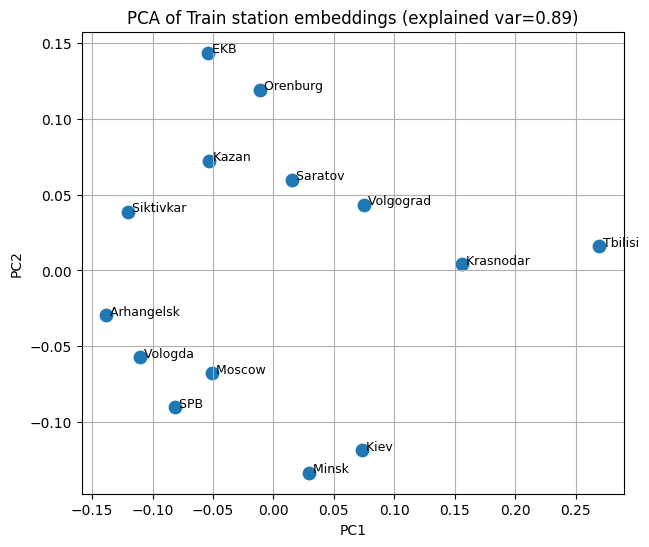

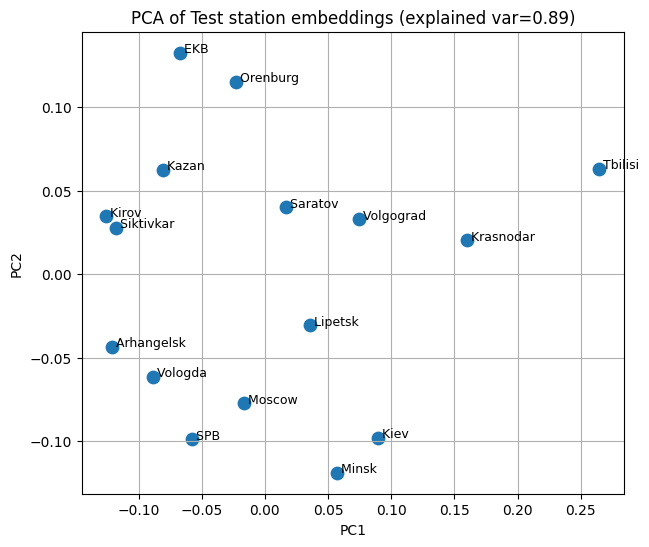

In [33]:
# ===== ВИЗУАЛИЗАЦИЯ GNN EMBEDDINGS С ПОМОЩЬЮ PCA =====
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_all_train)

plt.figure(figsize=(7, 6))
plt.scatter(z_pca[:, 0], z_pca[:, 1], s=80)

for i, name in enumerate(meta_train["name"]):
    plt.text(z_pca[i, 0], z_pca[i, 1], f" {name}", fontsize=9)

plt.title(f"PCA of Train station embeddings (explained var={pca.explained_variance_ratio_.sum():.2f})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_all_test)

plt.figure(figsize=(7, 6))
plt.scatter(z_pca[:, 0], z_pca[:, 1], s=80)

for i, name in enumerate(meta_test["name"]):
    plt.text(z_pca[i, 0], z_pca[i, 1], f" {name}", fontsize=9)

plt.title(f"PCA of Test station embeddings (explained var={pca.explained_variance_ratio_.sum():.2f})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

Карта практически не поменялась. Значит эмбеддинги новых точек корректны и не повлияли на всю структуру

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


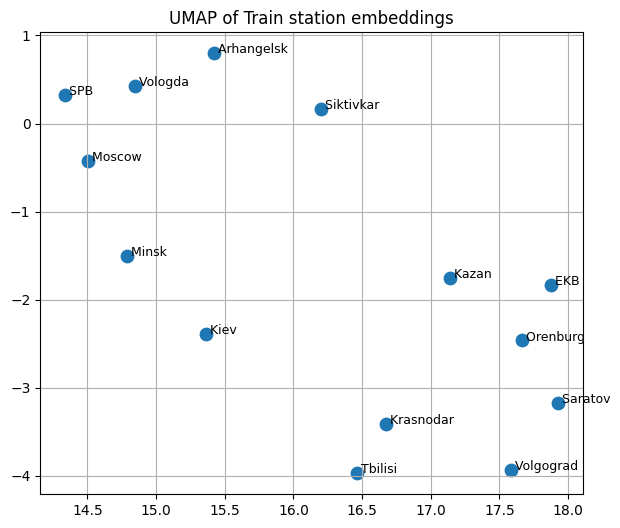

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


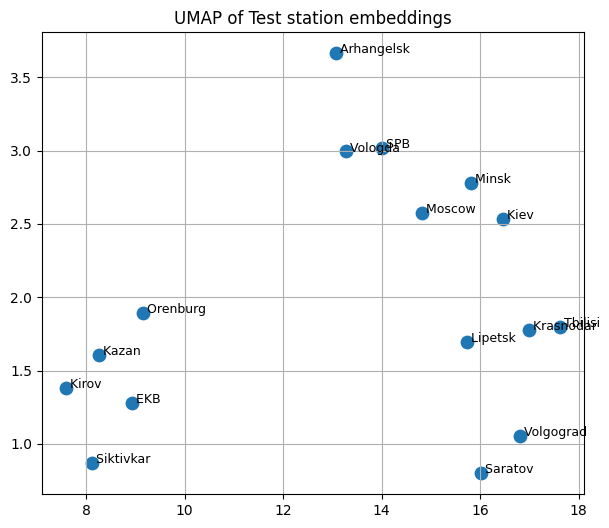

In [34]:
# ===== ВИЗУАЛИЗАЦИЯ GNN EMBEDDINGS С ПОМОЩЬЮ UMAP =====
reducer = umap.UMAP(
    n_neighbors=4,  # 4 ближайших соседа, так же как при построении графа
    min_dist=0.3,
    metric="euclidean",
    random_state=42
)

z_umap = reducer.fit_transform(z_all_train)

plt.figure(figsize=(7, 6))
plt.scatter(z_umap[:, 0], z_umap[:, 1], s=80)

for i, name in enumerate(meta_train["name"]):
    plt.text(z_umap[i, 0], z_umap[i, 1], f" {name}", fontsize=9)

plt.title("UMAP of Train station embeddings")
plt.grid(True)
plt.show()

reducer = umap.UMAP(
    n_neighbors=4, # 4 ближайших соседа, так же как при построении графа
    min_dist=0.3,
    metric="euclidean",
    random_state=42
)

z_umap = reducer.fit_transform(z_all_test) 

plt.figure(figsize=(7, 6))
plt.scatter(z_umap[:, 0], z_umap[:, 1], s=80)

for i, name in enumerate(meta_test["name"]):
    plt.text(z_umap[i, 0], z_umap[i, 1], f" {name}", fontsize=9)

plt.title("UMAP of Test station embeddings")
plt.grid(True)
plt.show()

Здесь нормально что карта поменялась. Новые точки "собрали" вокруг себя наиболее похожие

In [35]:
# Вытаскиваем GNN из обученной модели учителя, чтобы использовать его для получения эмбеддингов станций. Копируем его, чтобы не зависеть от состояния модели учителя.
gnn = copy.deepcopy(lit.model.gnn).cpu().eval()

torch.save(gnn.state_dict(), "station_embedder.pt")

# Обучение Student модели

In [36]:
# ===== ОПРЕДЕЛЕНИЕ МОДУЛЯ ОБУЧЕНИЯ =====
class StudentLightning(pl.LightningModule):
    def __init__(
        self,
        model: StudentModel,
        z_all: torch.Tensor,
        loss_cfg: HorizonLossConfig,
        lr_tcn: float = 3e-4,
        lr_bias: float = 1e-5,
        weight_decay: float = 5e-5,
        ema_decay: float = 0.999,
    ):
        super().__init__()
        self.model = model
        self.loss_fn = HorizonWeightedLoss(loss_cfg)

        self.register_buffer("z_all", z_all.float())

        self.lr_tcn = lr_tcn
        self.lr_gnn = lr_bias
        self.weight_decay = weight_decay
        self.ema = None
        self.ema_decay = ema_decay

    def forward(self, batch):
        return self.model(
            x_hist=batch["x_hist"],
            x_fut_cov=batch["x_fut_cov"],
            z=self.z_all[batch["station_id"]],
        )

    def training_step(self, batch, batch_idx):
        yhat = self(batch)
        y = batch["y"]
        loss, logs = self.loss_fn(yhat, y)

        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        for k, v in logs.items():
            if k != "loss":
                if k[:4] == "mae_" or k in ['loss_extreme', 'loss_diff', 'big_err_pen']:
                    self.log(f"train_{k}", v, prog_bar=True, on_step=False, on_epoch=True)
                else:
                    self.log(f"train_{k}", v, prog_bar=False, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        yhat = self(batch)
        y = batch["y"]
        loss, logs = self.loss_fn(yhat, y)

        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        for k, v in logs.items():
            if k != "loss":
                if k[:4] == "mae_":
                    self.log(f"val_{k}", v, prog_bar=True, on_step=False, on_epoch=True)
                else:
                    self.log(f"val_{k}", v, prog_bar=False, on_step=False, on_epoch=True)

    def on_fit_start(self):
        # тут модель уже на нужном device (cuda/cpu)
        self.ema = EMA(self.model, decay=self.ema_decay)
    
    def on_train_batch_end(self, outputs, batch, batch_idx):
        # EMA обновляем ПОСЛЕ optimizer step
        self.ema.update(self.model)

    def on_validation_epoch_start(self):
        if self.ema is not None:
            self.ema.apply_shadow(self.model)

    def on_validation_epoch_end(self):
        if self.ema is not None:
            self.ema.restore(self.model)

    def configure_optimizers(self):
        param_groups = []
        if self.model.tcn.use_bias_head:
            param_groups.append(
                {
                    "params": self.model.tcn.bias_head.parameters(),
                    "lr": self.lr_bias,
                    "weight_decay": 0.0,
                }
            )
            tcn_base_params = (
                p for p in self.model.tcn.parameters()
                if not any(p is bp for bp in self.model.tcn.bias_head.parameters())
            )
        else:
            tcn_base_params = self.model.tcn.parameters()

        param_groups.append(
            {
                "params": tcn_base_params,
                "lr": self.lr_tcn,
                "weight_decay": self.weight_decay,
            }
        )
        opt = torch.optim.AdamW(
            param_groups,
            betas=(0.9, 0.98),
        )

        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 129780, eta_min=1e-6) #ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=2, threshold=1e-3, min_lr=1e-6)
        return {
            "optimizer": opt,
            "lr_scheduler": {"scheduler": sch, "monitor": "val_mae_all"},
        }

In [ ]:
# ===== КОНФИГУРАЦИЯ ОБУЧЕНИЯ =====
loss_cfg = HorizonLossConfig(
    w_0_6h=1.4,
    w_6_24h=1.2,
    w_1_3d=1.1,
    w_3_7d=1.0,
    use_big_err_penalty=True,
    big_err_thresh=4.0,
    big_err_weight=0.3,
    lam_diff=0.03,
    use_extreme_weighting=True,
    cold_thresh=-14.0,
    hot_thresh=24.0,
    cold_weight=1.2,
    hot_weight=1.15,
    extreme_weight=0.08,
    use_std_penalty=True,
    tail_std_weight=0.04,
    tail_start=48,
    tail_end=168
)

pbar = TQDMProgressBar(refresh_rate=20)

d_hist = train_loader.dataset[0]["x_hist"].shape[-1]
d_cov  = train_loader.dataset[0]["x_fut_cov"].shape[-1]

student_core = StudentModel(
    d_hist=d_hist,
    d_fut_cov=d_cov,
    gnn_emb_dim=32,
    enc_channels=96,
    dec_channels=64,
    n_enc_layers=7,
    n_dec_layers=7,
    kernel_size=3,
    dropout=0.05,
)

lit = StudentLightning(
    model=student_core,
    z_all=z_all_train,
    loss_cfg=loss_cfg,
    lr_tcn=1e-4,
    weight_decay=1e-2,
    ema_decay=0.999
)

early_stop_callback = EarlyStopping(monitor="val_mae_all", min_delta=1e-4, patience=3, verbose=False, mode="min")
checkpoint_callback = ModelCheckpoint(save_top_k=3, monitor="val_mae_all", filename="student-{epoch:02d}-{val_mae_all:.3f}")

logger = CSVLogger(
    save_dir="logs",
    name="student_run"
)

trainer = pl.Trainer(
    limit_train_batches=1.0, # для быстрого тестирования, убрать или поставить 1.0 для полного прохода
    limit_val_batches=1.0, # для быстрого тестирования, убрать или поставить 1.0 для полного прохода
    max_epochs=10,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    gradient_clip_val=0.9,
    log_every_n_steps=50,
    logger=logger,
    callbacks=[early_stop_callback, checkpoint_callback, pbar],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [38]:
trainer.fit(lit, train_dataloaders=train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ StudentModel        │  575 K │ train │     0 │
│ 1 │ loss_fn │ HorizonWeightedLoss │      0 │ train │     0 │
└───┴─────────┴─────────────────────┴────────┴───────┴───────┘

Trainable params: 575 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 575 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 64                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:317: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 29.64it/s, v_num=7, val_loss=137.0, val_mae_0_6h=18.70, val_mae_6_24h=18.80, val_mae_1_3d=16.70, val_mae_3_7d=12.40, val_mae_all=14.60, train_loss=18.90, train_mae_0_6h=2.820, train_mae_6_24h=3.230, train_mae_1_3d=3.790, train_mae_3_7d=4.280, train_big_err_pen=7.710, train_loss_diff=0.671, train_loss_extreme=4.060, train_mae_all=3.970]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 27.35it/s, v_num=7, val_loss=137.0, val_mae_0_6h=18.70, val_mae_6_24h=18.80, val_mae_1_3d=16.70, val_mae_3_7d=12.40, val_mae_all=14.60, train_loss=18.90, train_mae_0_6h=2.820, train_mae_6_24h=3.230, train_mae_1_3d=3.790, train_mae_3_7d=4.280, train_big_err_pen=7.710, train_loss_diff=0.671, train_loss_extreme=4.060, train_mae_all=3.970]


In [40]:
# ===== ЗАГРУЗКА СОХРАНЁННОЙ МОДЕЛИ СТУДЕНТА =====
# ВНИМАНИЕ: Убедитесь, что путь к контрольной точке модели указан правильно.
# Также убедитесь, что при загрузке модели вы используете те же параметры для node_features_all, edge_index и edge_weight, что и при обучении, иначе могут возникнуть ошибки несовпадения форматов.
lit = StudentLightning.load_from_checkpoint(r'logs\student_run\version_6\checkpoints\student-epoch=02-val_mae_all=3.053.ckpt', model=student_core,
    z_all=z_all_train, loss_cfg=loss_cfg, map_location='cpu')

In [ ]:
# Только при необходимости.
# ВНИМАНИЕ: EMA не сохраняется в чекпоинтах
lit.ema.apply_shadow(lit.model)

AttributeError: 'NoneType' object has no attribute 'apply_shadow'

In [42]:
yhat, y, sid, t0 = predict_on_loader(lit, test_loader)

stats = mae_by_ranges_per_station(yhat, y, sid)
for st, s in stats.items():
    print("station", st, s)

station 10 {'MAE_all': 3.3910791873931885, 'MAE_0-6h': 0.7799026966094971, 'MAE_6-24h': 1.7464570999145508, 'MAE_1-3d': 2.9913597106933594, 'MAE_3-7d': 4.062503814697266}
station 12 {'MAE_all': 3.15421462059021, 'MAE_0-6h': 0.841911256313324, 'MAE_6-24h': 1.7562470436096191, 'MAE_1-3d': 2.8806049823760986, 'MAE_3-7d': 3.697659730911255}


In [43]:
std_true = np.std(y, axis=1)
std_pred = np.std(yhat, axis=1)

(std_pred / std_true + 1e-6).mean()

np.float32(0.78221714)

In [44]:
lit._buffers["z_all"] = z_all_test.to(lit.device)

In [45]:
yhat_test, y_test, sid_test, t0_test = predict_on_loader(lit, test_unseen_loader)

stats_test = mae_by_ranges_per_station(yhat_test, y_test, sid_test)
for st, s in stats_test.items():
    print("station", st, s)

station 14 {'MAE_all': 2.991018772125244, 'MAE_0-6h': 0.8504197001457214, 'MAE_6-24h': 1.7273919582366943, 'MAE_1-3d': 2.7433340549468994, 'MAE_3-7d': 3.485577344894409}
station 15 {'MAE_all': 3.6276473999023438, 'MAE_0-6h': 0.8431172370910645, 'MAE_6-24h': 1.9759913682937622, 'MAE_1-3d': 3.330759048461914, 'MAE_3-7d': 4.259809970855713}


In [46]:
std_true = np.std(y_test, axis=1)
std_pred = np.std(yhat_test, axis=1)

np.mean(std_pred / std_true + 1e-6)

np.float32(0.803866)

In [47]:
t0_dt = t0h_to_datetime(t0)
t0_dt_test = t0h_to_datetime(t0_test)

In [48]:
df_season = seasonal_mae_bias(yhat, y, sid, t0_dt)
df_season

station_id season  n_windows   MAE_all  Bias_all
0          10    DJF       1992  5.253994 -2.969105
2          10    JJA       2208  2.172468 -0.431021
1          10    MAM       2208  3.733445 -1.232650
3          10    SON       2184  2.577810 -1.072563
4          12    DJF       1944  3.984059  0.063753
6          12    JJA       2208  2.470945 -0.046768
5          12    MAM       2208  3.343494 -1.884051
7          12    SON       2184  2.914985 -1.292023

In [49]:
df_season_test = seasonal_mae_bias(yhat_test, y_test, sid_test, t0_dt_test)
df_season_test

station_id season  n_windows   MAE_all  Bias_all
0          14    DJF       1992  3.458915  0.894885
2          14    JJA       2208  2.455480  0.489442
1          14    MAM       2208  3.489074 -1.158646
3          14    SON       2184  2.602147 -0.098361
4          15    DJF       1944  5.843030 -2.675303
6          15    JJA       2208  2.361485 -1.024541
5          15    MAM       2208  3.622038 -1.988646
7          15    SON       2184  2.941460 -1.655264

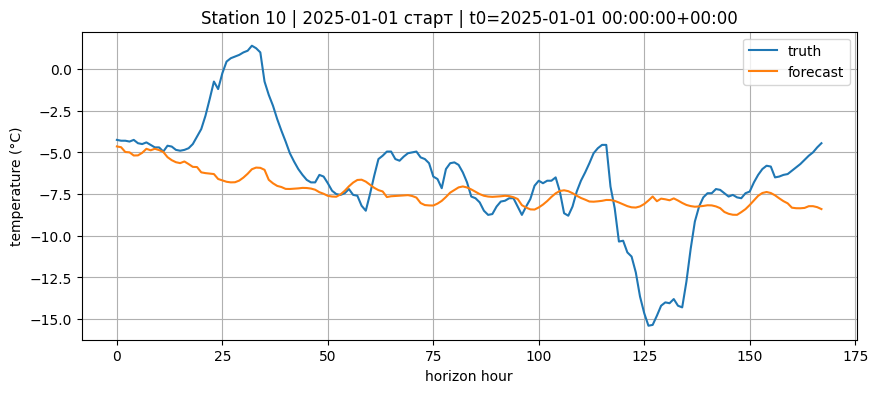

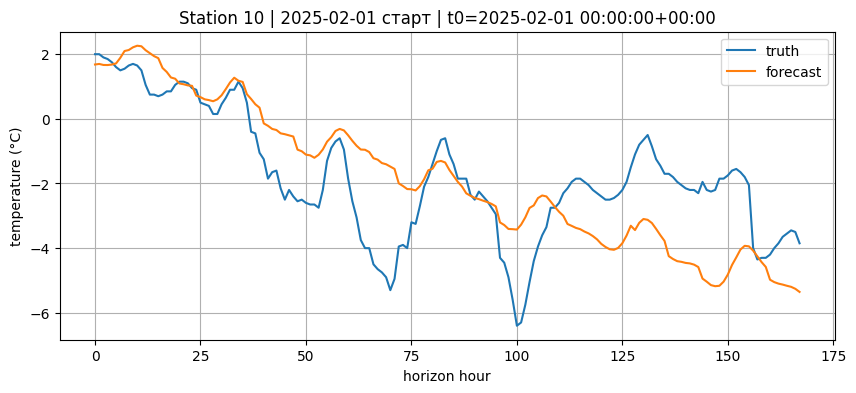

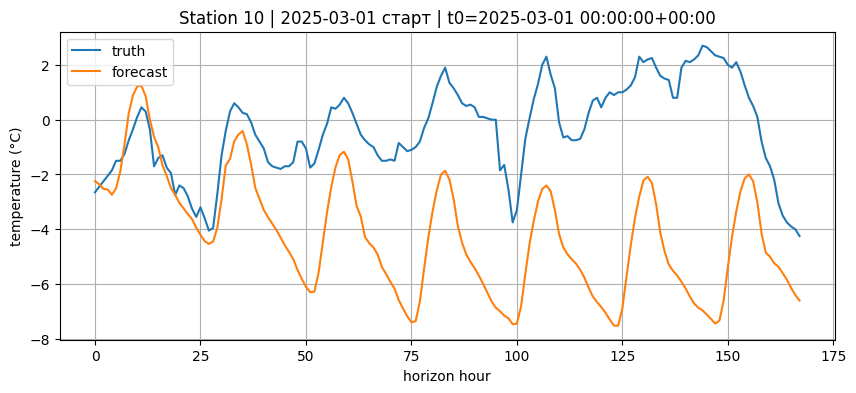

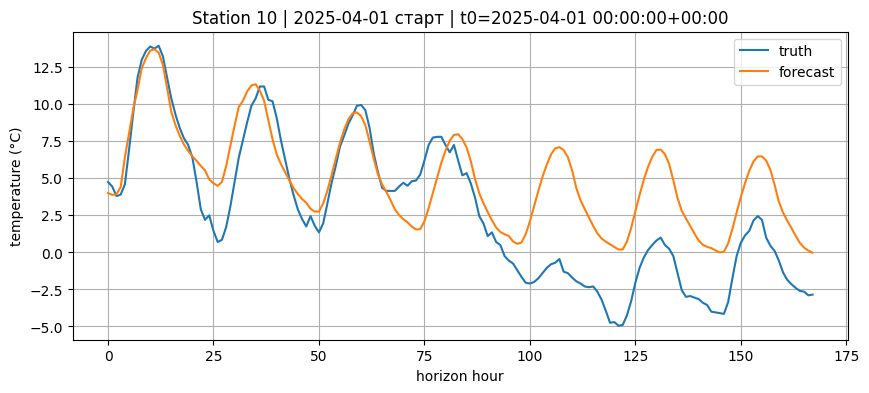

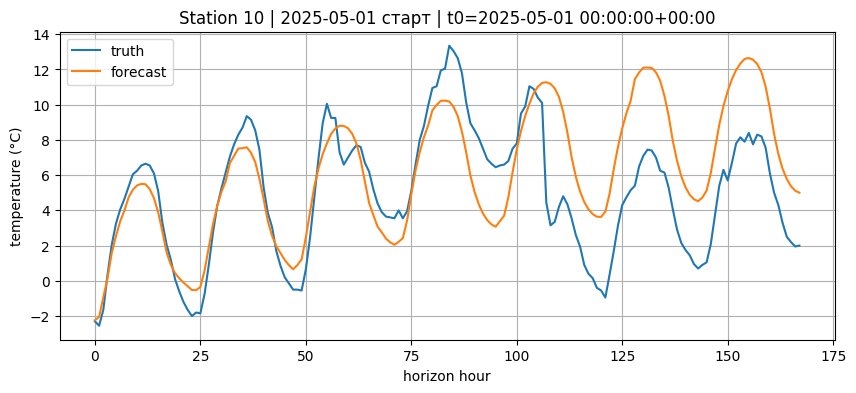

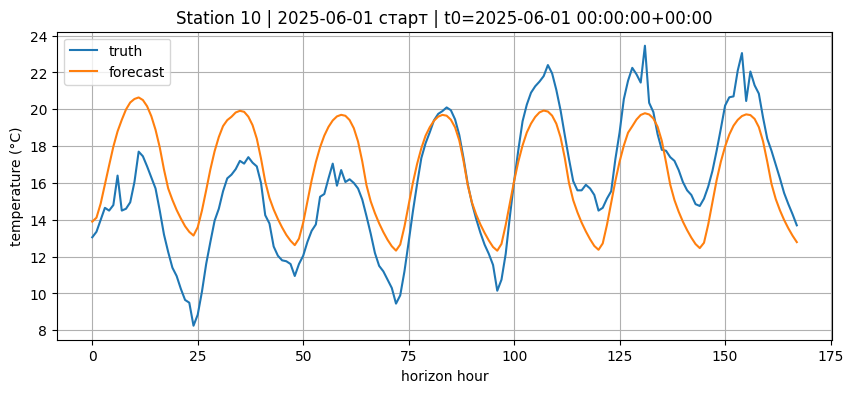

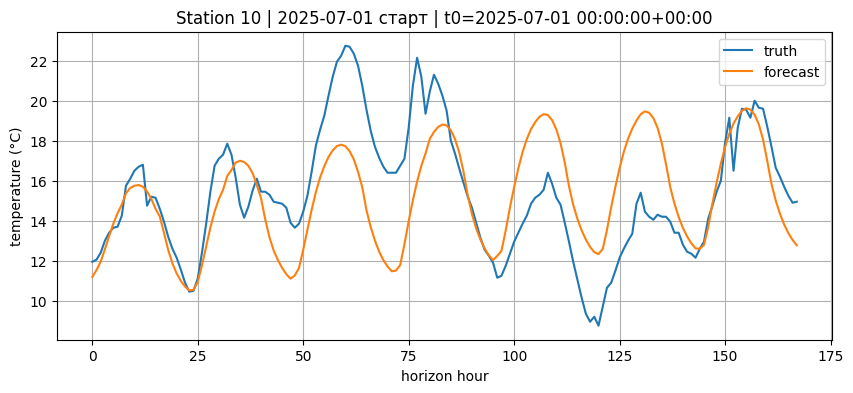

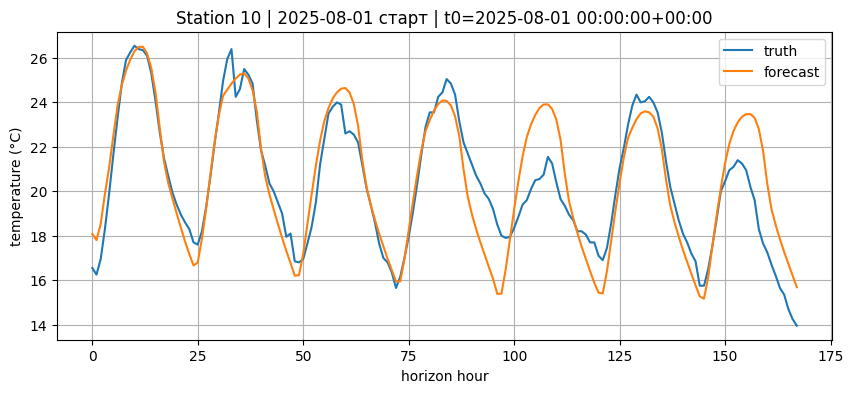

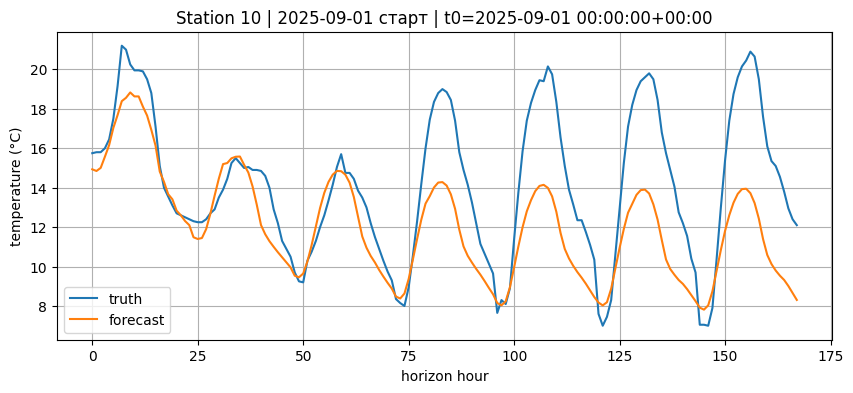

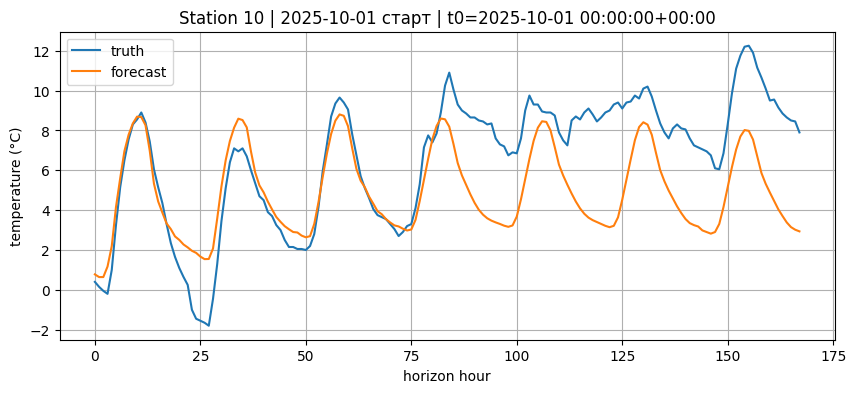

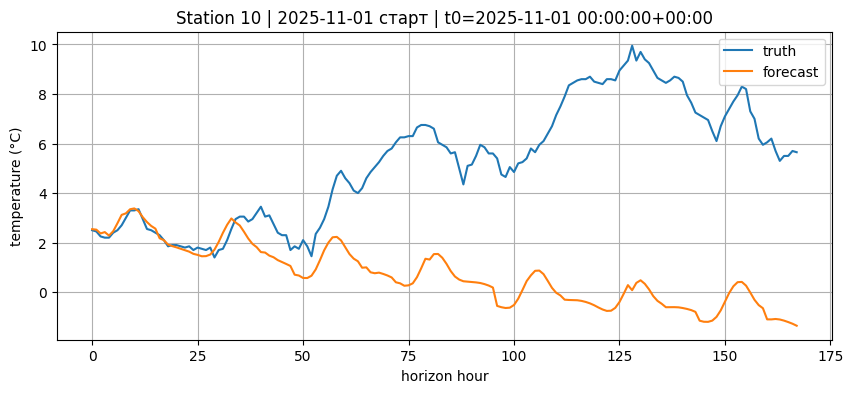

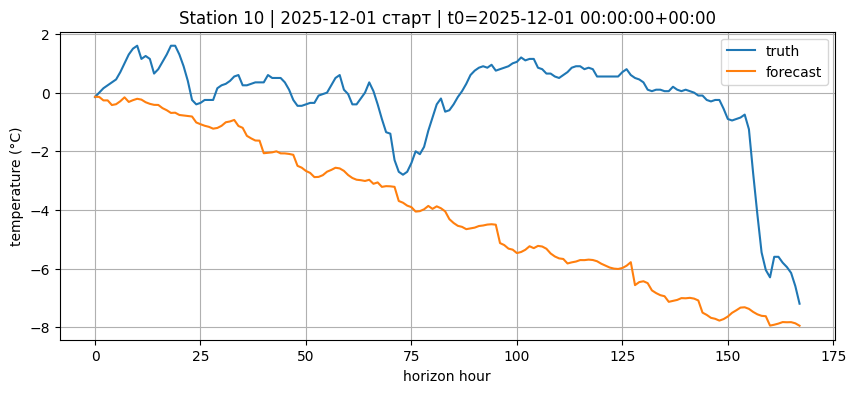

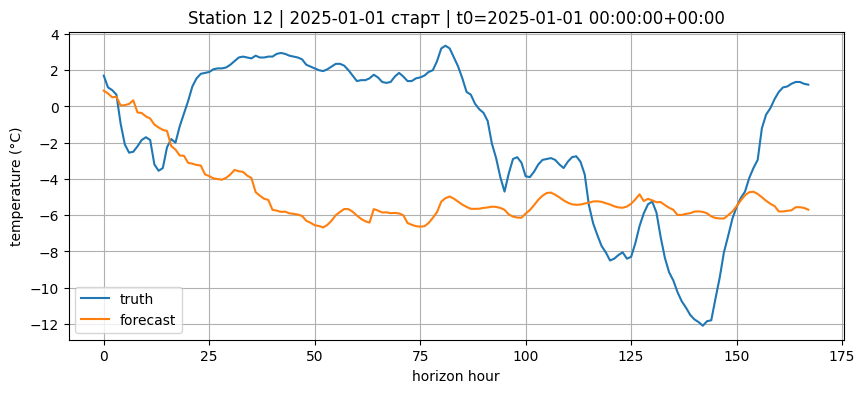

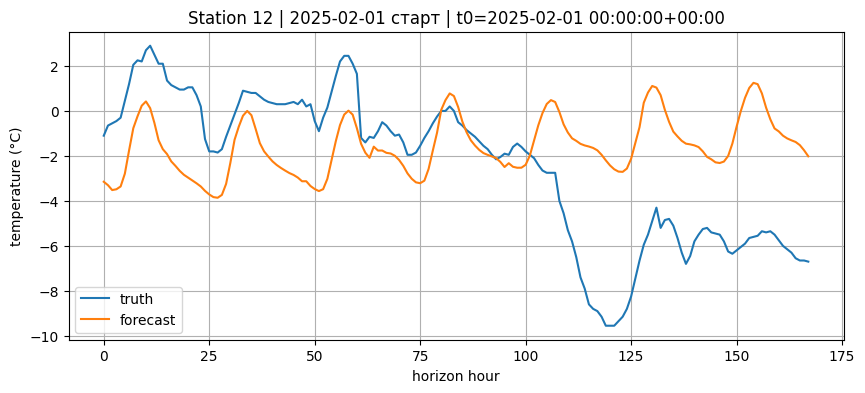

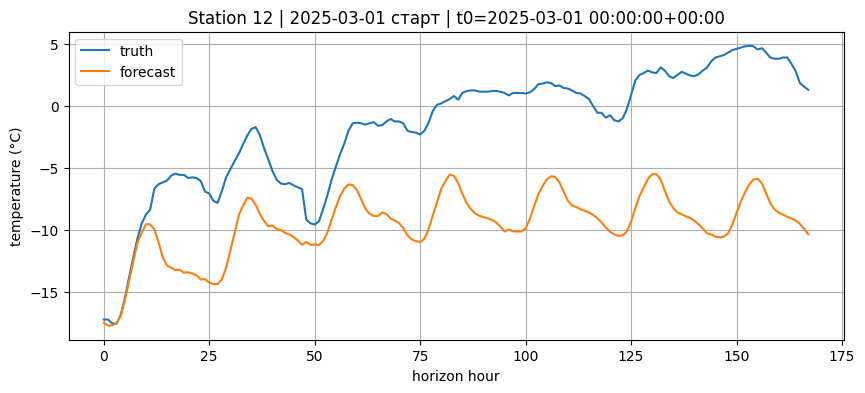

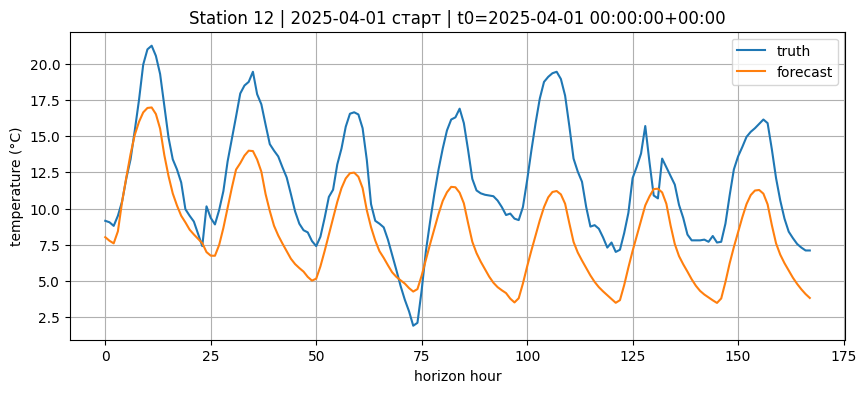

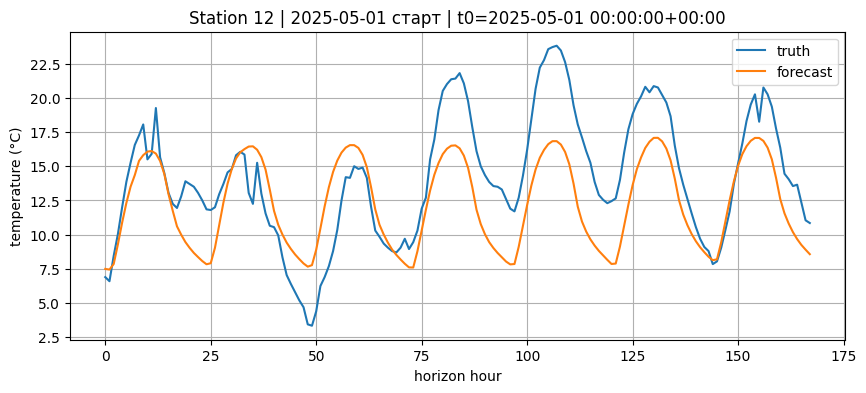

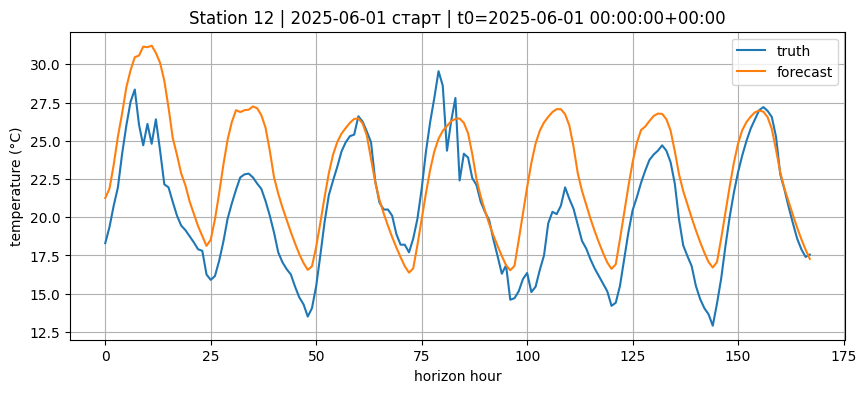

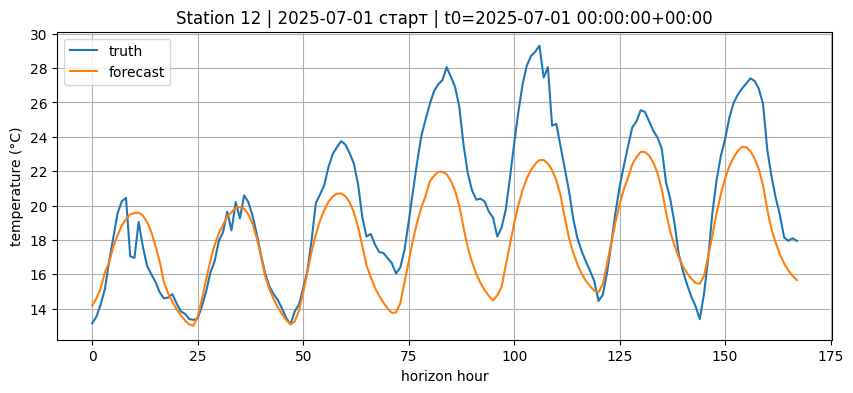

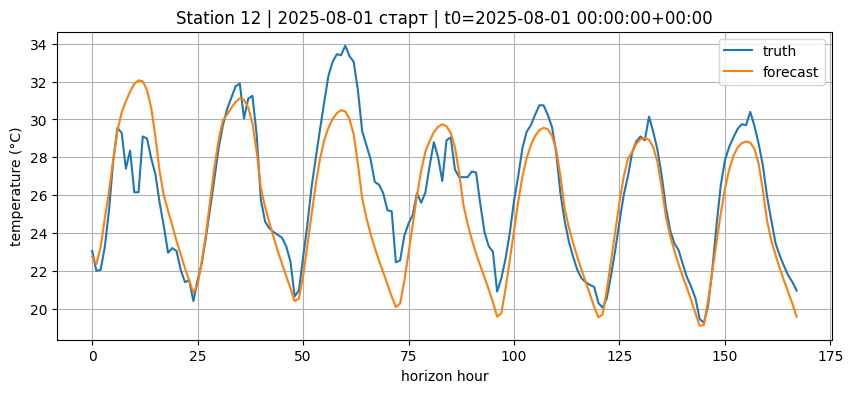

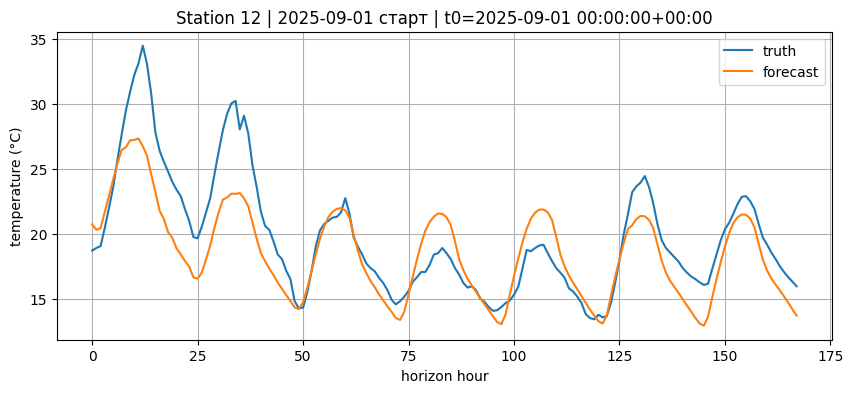

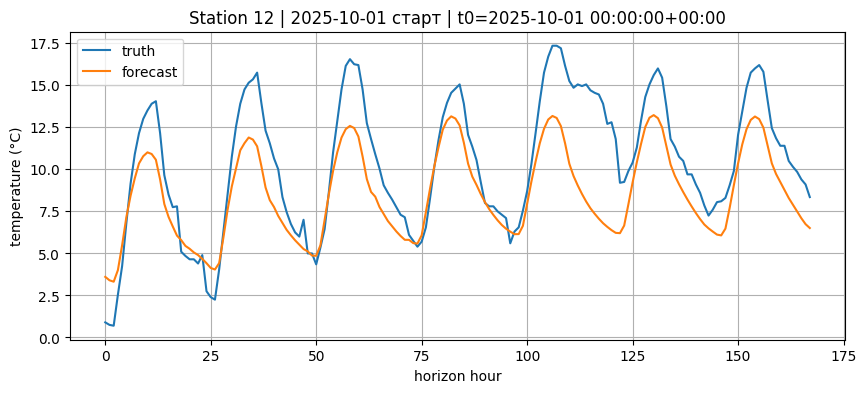

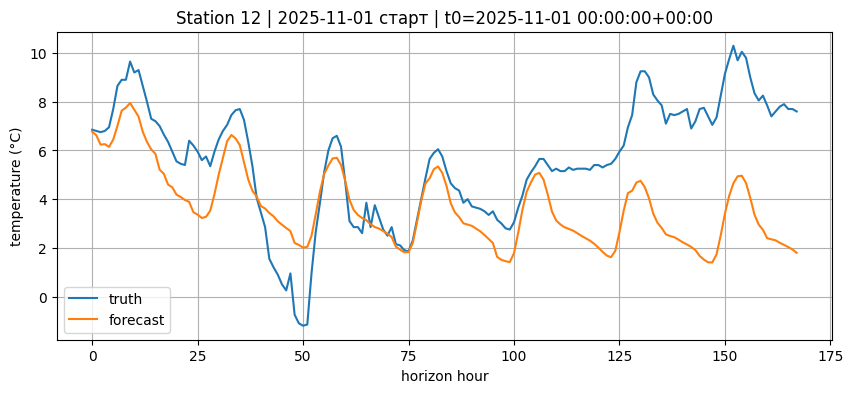

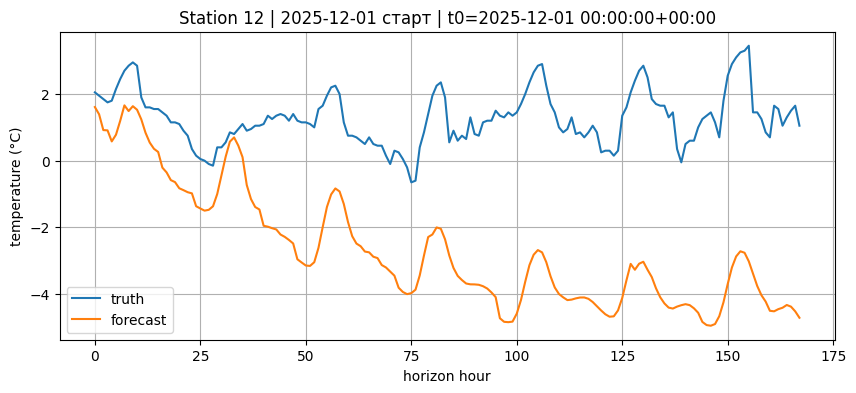

In [50]:
for st in np.unique(sid):
    plot_monthly_forecast_one_shot(yhat, y, sid, t0, station_id=int(st), H=y.shape[1])

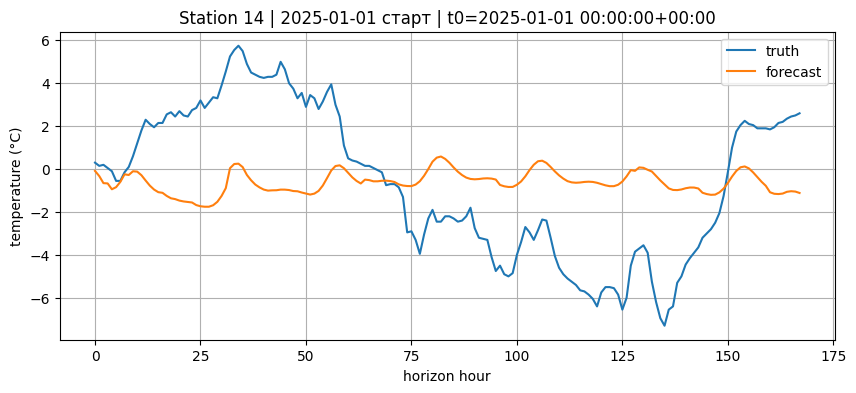

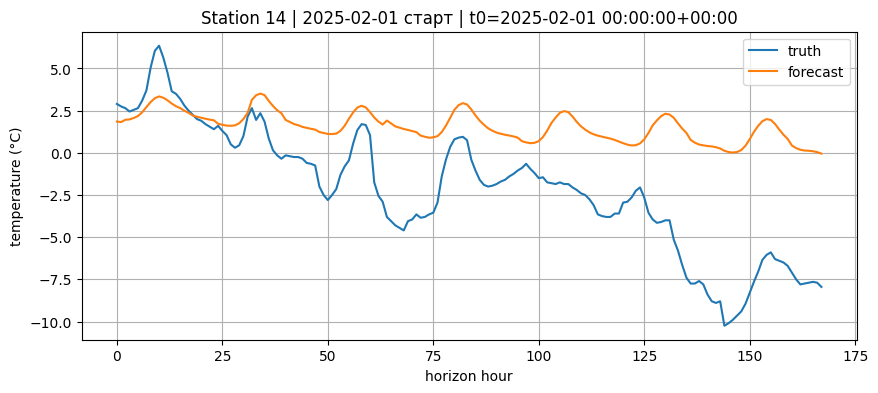

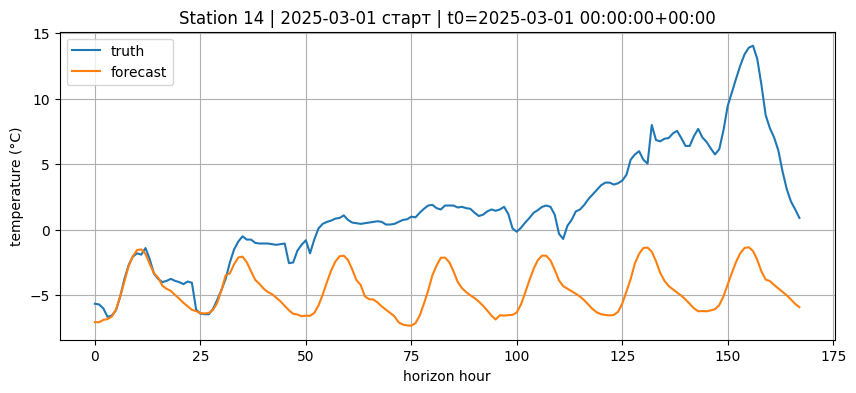

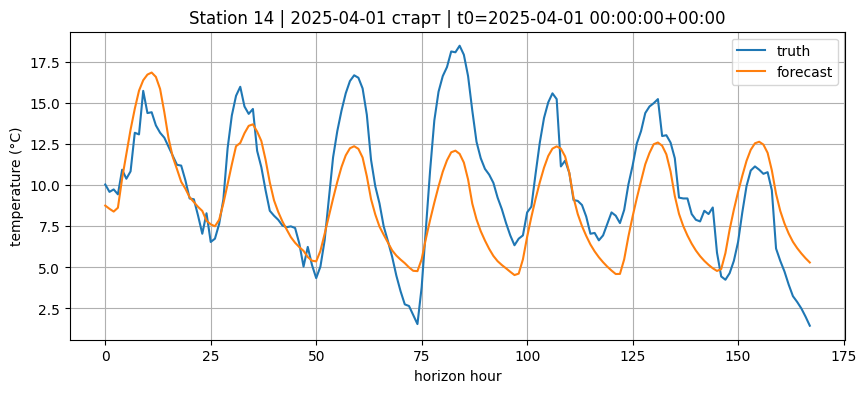

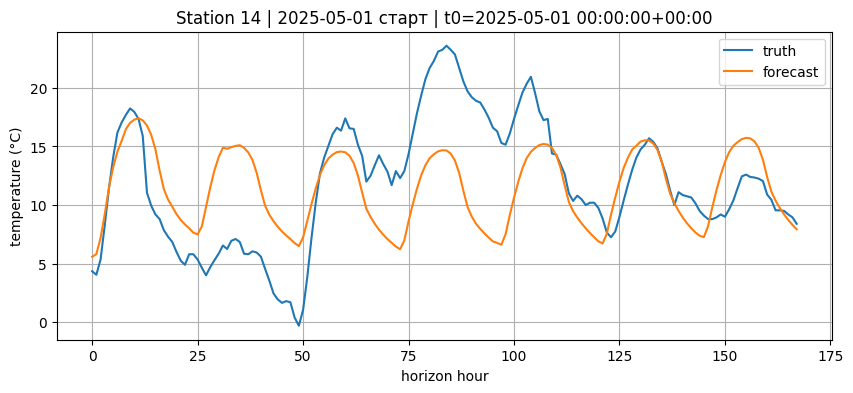

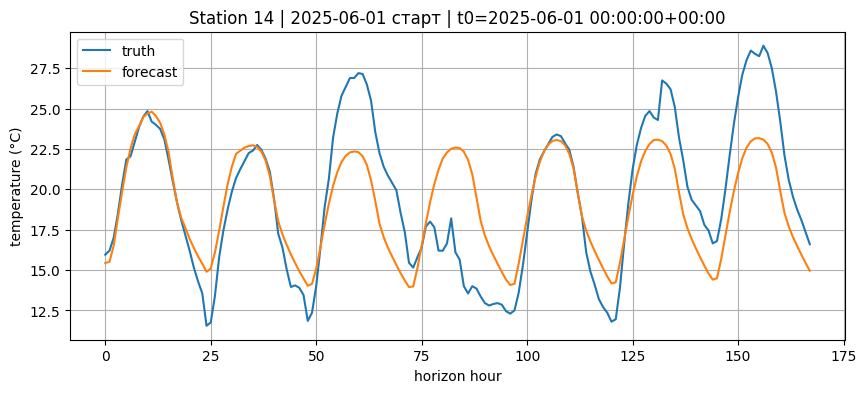

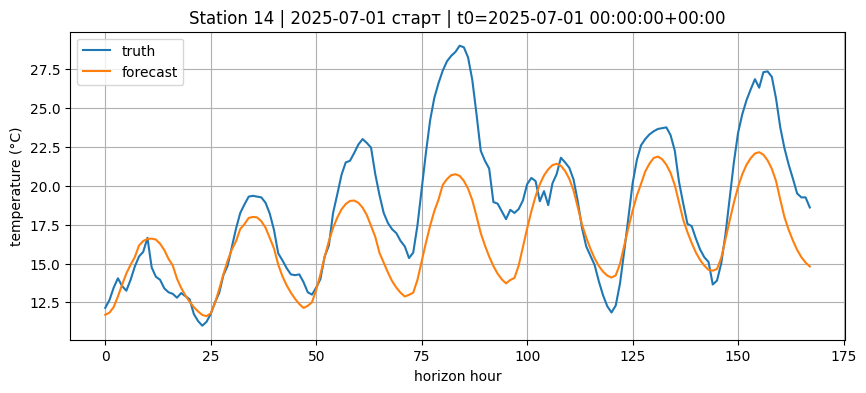

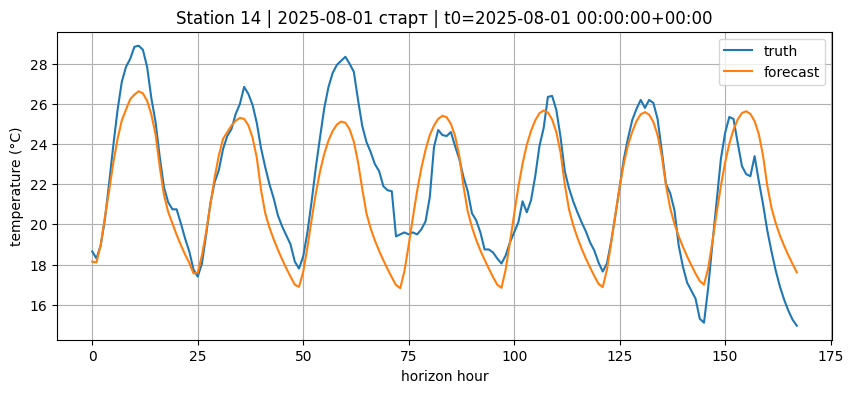

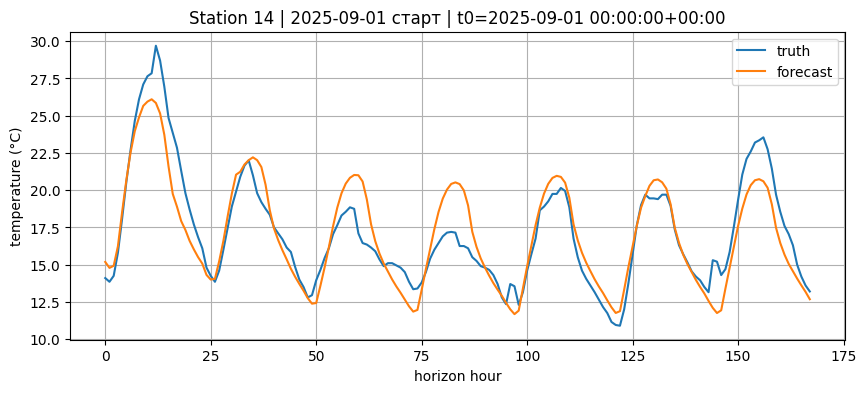

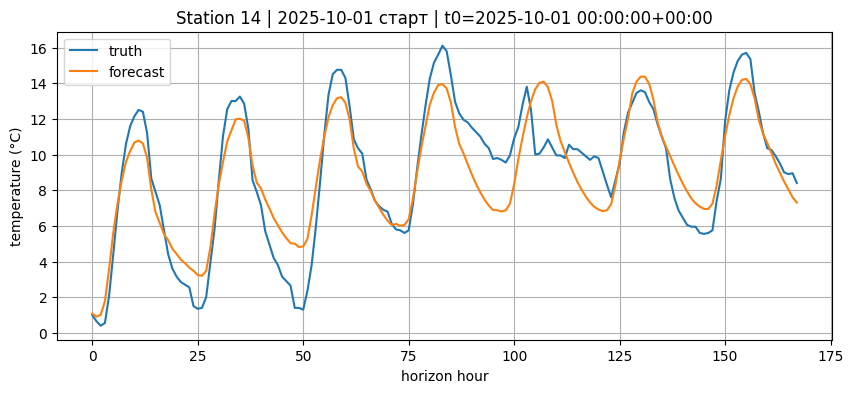

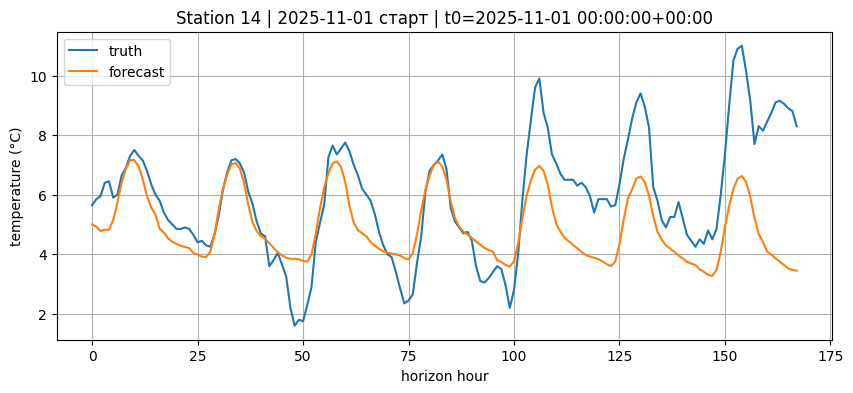

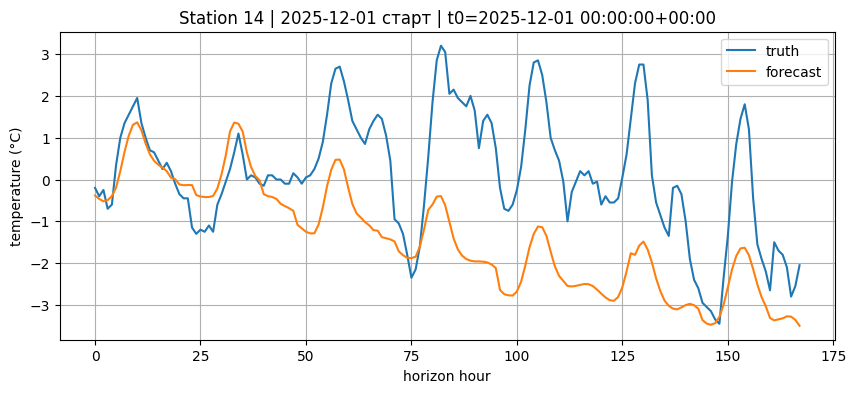

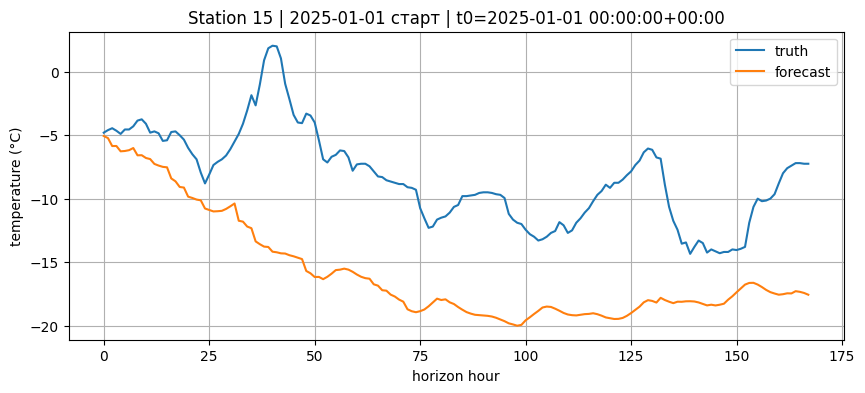

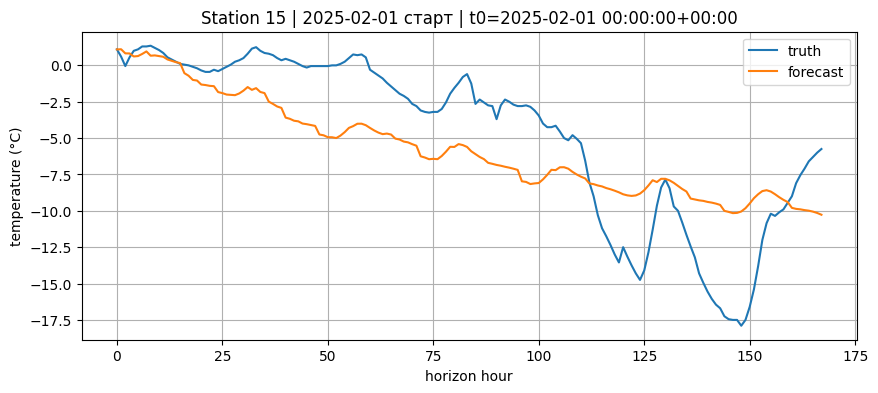

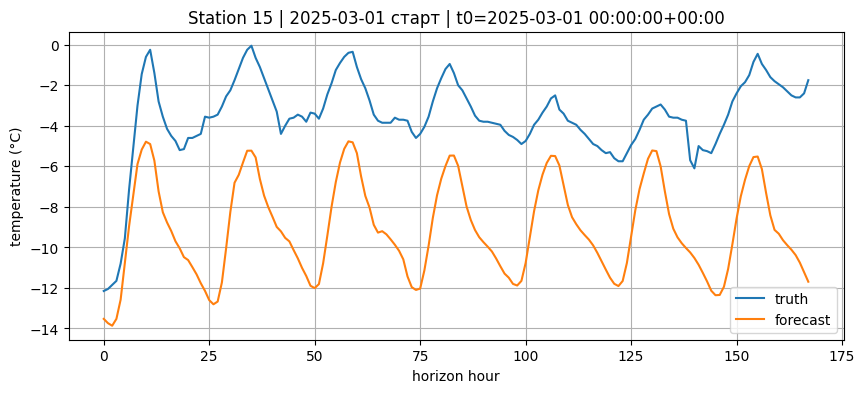

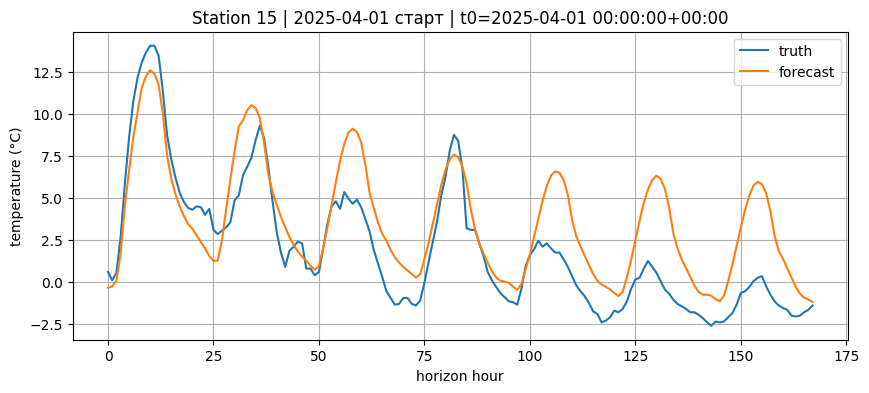

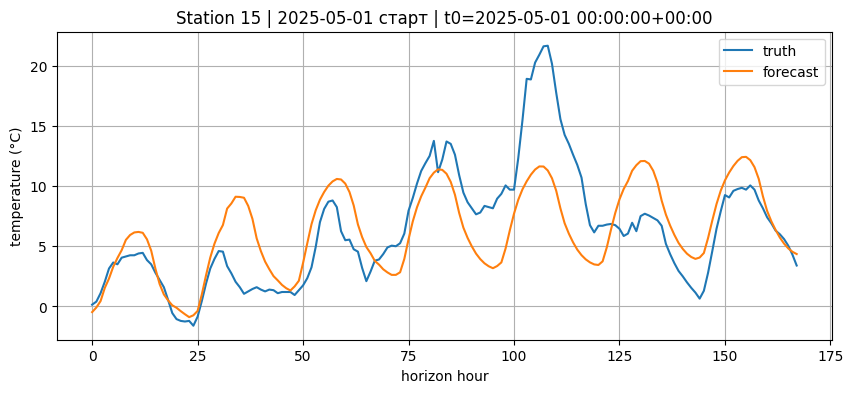

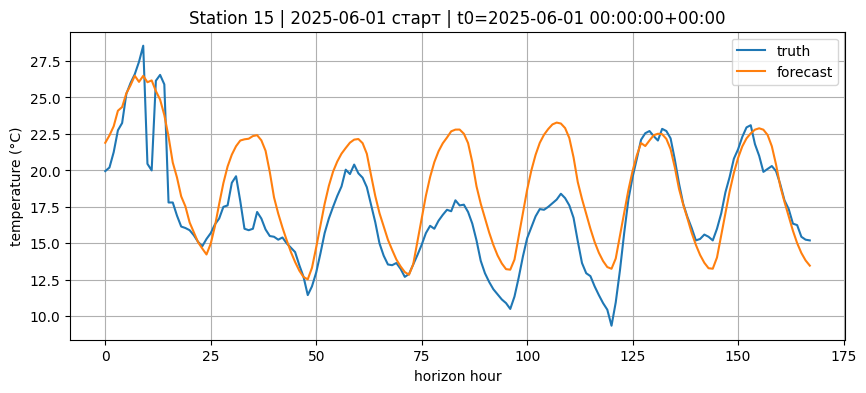

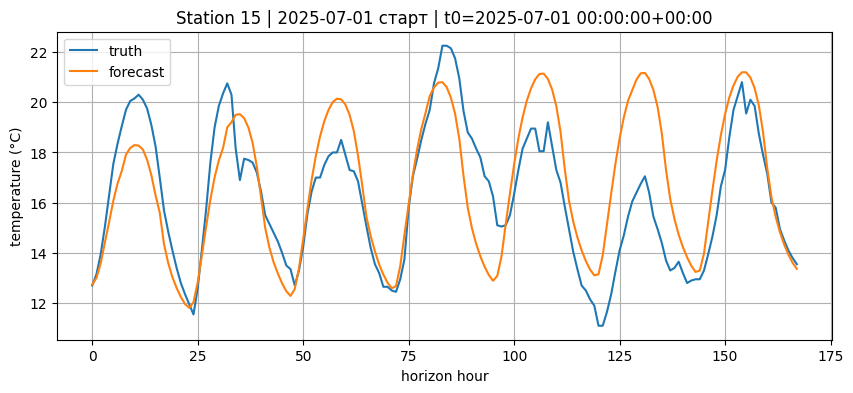

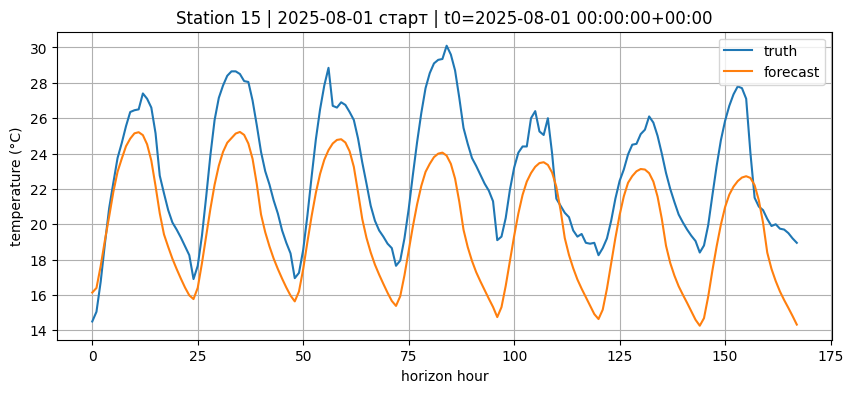

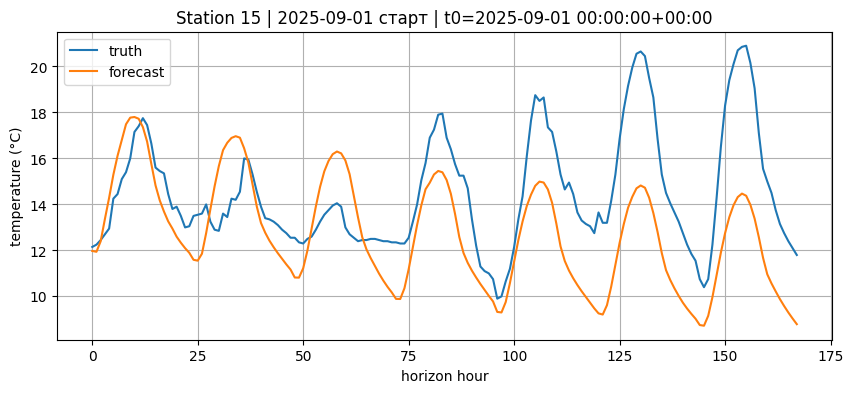

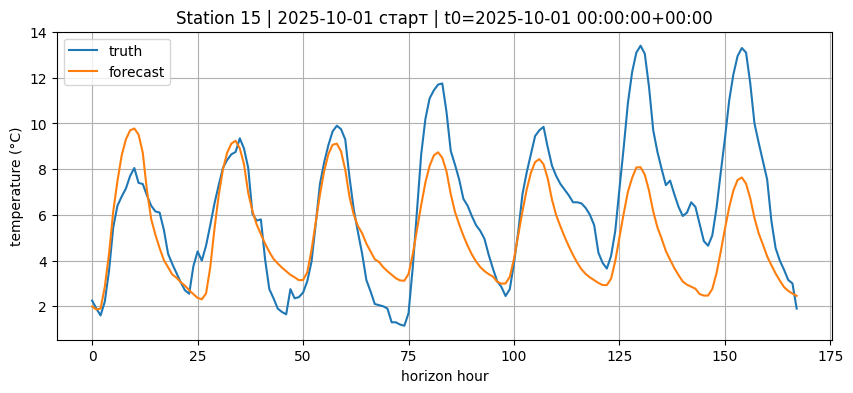

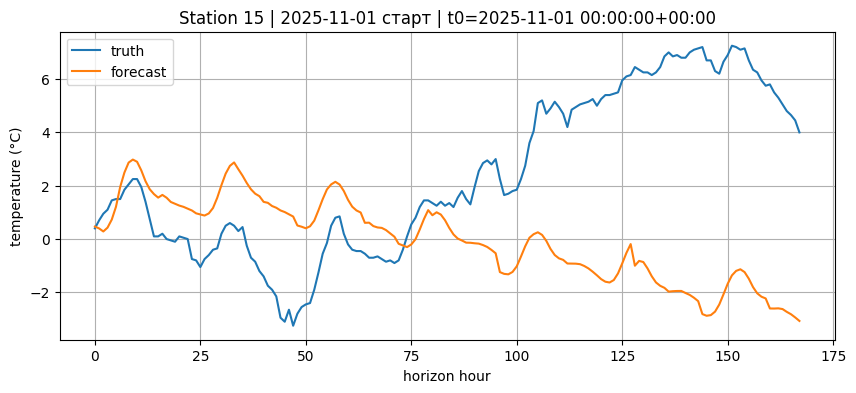

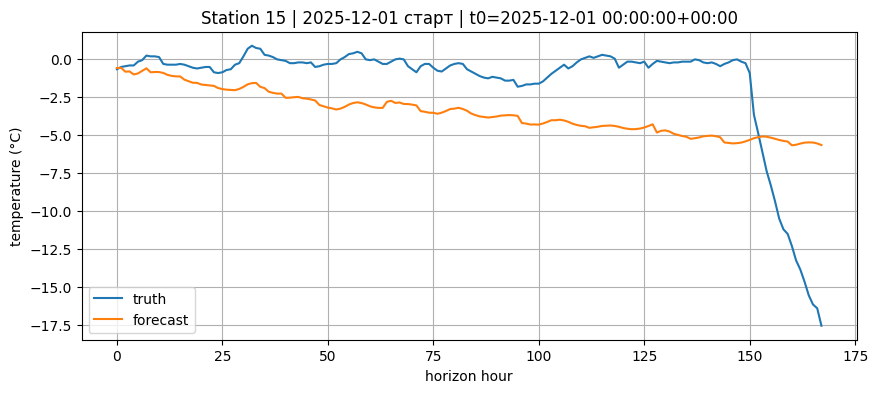

In [51]:
for st in np.unique(sid_test):
    plot_monthly_forecast_one_shot(yhat_test, y_test, sid_test, t0_test, station_id=int(st), H=y_test.shape[1])

In [53]:
# Сохраняем модель
torch.save(lit.model.state_dict(), "final_model.pt")